# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports et nettoyage

### Imports et chemins

In [520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
from pathlib import Path

# Chemins
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_CSV     = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Racine projet :", PROJECT_ROOT)
print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

📁 Racine projet : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ
CSV présent : True - /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/data/processed/final_dataset.csv


### Lecture et nettoyage du jeu de données

In [521]:
# Chargement initial
df_full = (
    pd.read_csv(
        DATA_CSV,
        parse_dates=["date", "closed_at", "cve_pub"],
        keep_default_na=False
    )
    .replace({"n/a": np.nan, "": np.nan})
)

# Typage numérique + explosion versions
for col in ["cvss_score","epss_score","epss_percentile","lag_anssi_days","days_open", "n_revisions"]:
    if col in df_full: df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

# Vues à disposer
df_publi       = df_full.copy()                                             # toutes les lignes
df_clean       = df_full.dropna(subset=["cvss_score","epss_score"]).copy()  # pour scatter/violon…
df_unique_all  = (df_publi
                    .sort_values("date")
                    .drop_duplicates(subset=["cve"])
                    .copy())                                                   # pour cumuls, top vendors…
df_unique_scores = (df_clean
                      .sort_values("date")
                      .drop_duplicates(subset=["cve"])
                      .copy())                                                 # pour scatter unique,…

print("• df_publi       :", df_publi.shape)
print("• df_clean       :", df_clean.shape)
print("• df_unique_all  :", df_unique_all.shape)
print("• df_unique_scores:", df_unique_scores.shape)

• df_publi       : (268010, 22)
• df_clean       : (90329, 22)
• df_unique_all  : (39000, 22)
• df_unique_scores: (10984, 22)


## Exploration initiale du DataFrame

Avant de rentrer dans le cœur de nos visualisations, il est important d'explorer notre DataFrame afin d'avoir une première impression de la situation à analyser.

### Vue d'ensemble

In [522]:
print("Dimensions :", df_publi.shape)
display(df_publi.dtypes)
display(df_publi.head())
display(df_publi.tail())

Dimensions : (268010, 22)


id_anssi                   object
type                       object
titre                      object
n_revisions                 int64
date               datetime64[ns]
closed_at          datetime64[ns]
lien                       object
cve                        object
description                object
cvss_score                float64
cvss_sev                   object
cwe                        object
cwe_description            object
n_cve_refs                  int64
cve_pub            datetime64[ns]
lag_anssi_days            float64
epss_score                float64
epss_percentile           float64
vendor                     object
vendor_std                 object
produit                    object
days_open                   int64
dtype: object

,id_anssi,type,titre,n_revisions,date,closed_at,lien,cve,description,cvss_score,...,cwe_description,n_cve_refs,cve_pub,lag_anssi_days,epss_score,epss_percentile,vendor,vendor_std,produit,days_open
0,CERTFR-2023-AVI-0963,avis,Vulnérabilité dans les produits Cisco,1,2023-11-20,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2023-...,CVE-2023-44487,The HTTP/2 protocol allows a denial of service...,NaN,...,NaN,140,2023-10-10,41.0,0.94434,0.99983,NaN,NaN,NaN,576
1,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-38310,Improper access control in some Intel(R) Graph...,8.2,...,Escalation of Privilege,1,2025-02-12,0.0,0.00015,0.01816,NaN,NaN,Intel(R) Graphics Driver software installers,126
2,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-25571,Improper input validation in some Intel(R) SPS...,2.3,...,Denial of Service,1,2025-02-12,0.0,0.00020,0.03603,NaN,NaN,Intel(R) SPS firmware before SPS_E5_06.01.04.0...,126
3,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2023-34440,Improper input validation in UEFI firmware for...,7.5,...,Escalation of Privilege,1,2025-02-12,0.0,0.00028,0.06177,NaN,NaN,Intel(R) Processors,126
4,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-37020,Sequence of processor instructions leads to un...,3.8,...,Denial of Service,1,2025-02-12,0.0,0.00027,0.05858,NaN,NaN,Intel(R) Xeon(R) Processors,126


,id_anssi,type,titre,n_revisions,date,closed_at,lien,cve,description,cvss_score,...,cwe_description,n_cve_refs,cve_pub,lag_anssi_days,epss_score,epss_percentile,vendor,vendor_std,produit,days_open
268005,CERTFR-2020-AVI-001,avis,Multiples vulnérabilités dans Cisco DCNM,1,2020-01-02,2020-01-02,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-001,CVE-2019-15977,NaN,NaN,...,NaN,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
268006,CERTFR-2020-AVI-001,avis,Multiples vulnérabilités dans Cisco DCNM,1,2020-01-02,2020-01-02,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-001,CVE-2019-15985,Multiple vulnerabilities in the REST and SOAP ...,7.2,...,CWE-89,1,2020-01-06,-4.0,0.03989,0.87899,Cisco,Cisco,Cisco Data Center Network Manager,0
268007,CERTFR-2020-AVI-001,avis,Multiples vulnérabilités dans Cisco DCNM,1,2020-01-02,2020-01-02,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-001,CVE-2019-15984,Multiple vulnerabilities in the REST and SOAP ...,7.2,...,CWE-89,2,2020-01-06,-4.0,NaN,NaN,Cisco,Cisco,Cisco Data Center Network Manager,0
268008,CERTFR-2020-AVI-001,avis,Multiples vulnérabilités dans Cisco DCNM,1,2020-01-02,2020-01-02,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-001,CVE-2019-15979,Multiple vulnerabilities in the REST and SOAP ...,7.2,...,CWE-78,1,2020-01-06,-4.0,0.03989,0.87899,Cisco,Cisco,Cisco Data Center Network Manager,0
268009,CERTFR-2020-AVI-001,avis,Multiples vulnérabilités dans Cisco DCNM,1,2020-01-02,2020-01-02,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-001,CVE-2019-15976,Multiple vulnerabilities in the authentication...,9.8,...,CWE-798,2,2020-01-06,-4.0,NaN,NaN,Cisco,Cisco,Cisco Data Center Network Manager,0


Le DataFrame possède 268010 lignes et 22 colonnes ce qui en fait un jeu de données très riche.

Les 22 colonnes et leurs types (strings, dates, float, int) confirment qu’on dispose à la fois de métadonnées temporelles, de scores numériques, de catégories et de textes pour chaque CVE.

On voit que le même CVE apparaît plusieurs fois avec des produits différents. Cela explique pourquoi le nombre de lignes est bien supérieur au nombre de CVE uniques.

### Valeurs manquantes

In [523]:
missing = df_publi.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

cvss_score         129959
cvss_sev           129959
epss_percentile     97115
epss_score          97115
cwe                 90917
cwe_description     90917
description         73656
vendor_std          40477
vendor              40477
produit             29105
cve_pub             16390
lag_anssi_days      16390
cve                   330
dtype: int64

On remarque de ce comptage que :
* EPSS (score et percentiles) sont absents dans environ 9 % des lignes, car l’API EPSS ne couvre pas tous les CVE (notamment les très récents ou les anciens hors lot traité).
* CVSS (score et sévérité) manquent dans environ 50 % des cas, la raison principale étant que certains bulletins ANSSI listent un CVE sans reprendre son score CVSS.
* CWE et descriptions MITRE sont indisponibles pour environ 36 % des vulnérabilités, sans doute parce que de nombreuses CVE n’ont pas encore de "problemType" officiellement classé par MITRE (surtout très récentes ou très anciennes).
* La quasi totalité des lignes contiennent bien un identifiant CVE, ce qui garantit un bon alignement avec les bases externes.

### Nombre de bulletins par type

In [524]:
display(df_publi["type"].value_counts())

type
avis      266277
alerte      1733
Name: count, dtype: int64

L’immense domination des avis est attendue et reflète la politique éditoriale de l’ANSSI. En effet, l'ANSSI déclenche une alerte seulement pour les CVE ayant un impact très élevé, ce qui explique leur extrême rareté. Tandis que les avis sont publiés de manière beaucoup plus systématique (régulièrement, parfois plusieurs fois par semaine) pour couvrir l’ensemble du spectre des vulnérabilités.

### Période couverte

In [525]:
print(df_publi["date"].min().date(), "→", df_publi["date"].max().date())

2020-01-02 → 2025-06-18


### Volume mensuel de publications ANSSI

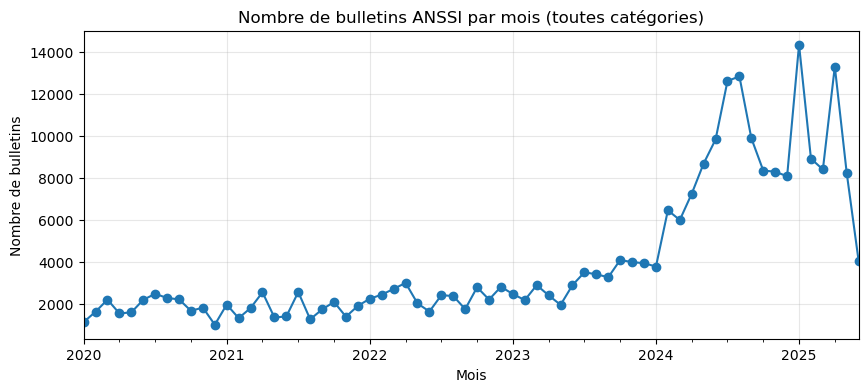

In [526]:
monthly_counts = df_publi.set_index("date")["type"].resample("ME").count()
plt.figure(figsize=(10,4))
monthly_counts.plot(marker="o")
plt.title("Nombre de bulletins ANSSI par mois (toutes catégories)")
plt.ylabel("Nombre de bulletins")
plt.xlabel("Mois")
plt.grid(alpha=0.3)
plt.show()

On remarque clairement deux tendances sur deux périodes :
* **2020 – mi-2023** : un rythme assez stable autour de 1 200–2 000 bulletins/mois, avec de petites crêtes ponctuelles (fin d’année, nouveaux gros correctifs Windows/Linux, etc.).
* **À partir de début 2024** : forte montée en charge, avec plus de 8 000–13 000 bulletins en 2025. Le chiffre plus bas de bulletin au moins de juin est normal... car nous sommes en plein milieu !

### Distribution des scores CVSS et EPSS (tous bulletins)

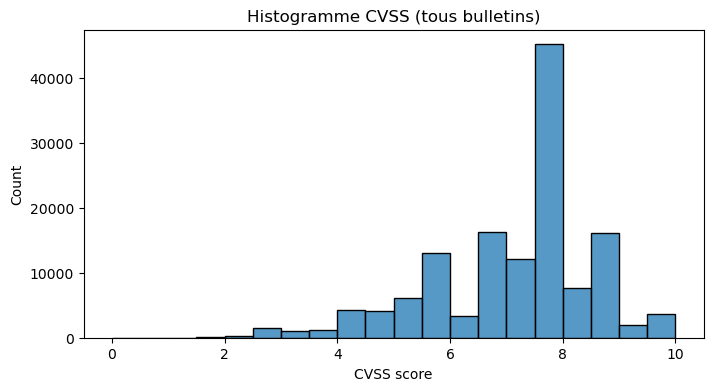

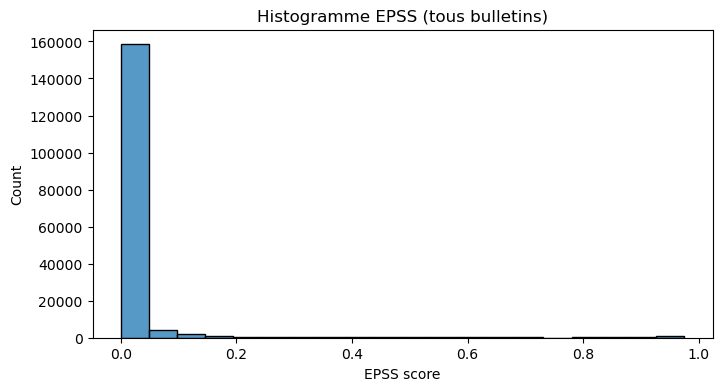

In [527]:
# CVSS
plt.figure(figsize=(8,4))
sns.histplot(df_publi["cvss_score"].dropna(), bins=20, kde=False)
plt.title("Histogramme CVSS (tous bulletins)")
plt.xlabel("CVSS score")
plt.show()

# EPSS
plt.figure(figsize=(8,4))
sns.histplot(df_publi["epss_score"].dropna(), bins=20, kde=False)
plt.title("Histogramme EPSS (tous bulletins)")
plt.xlabel("EPSS score")
plt.show()

Concernant la répartition des CVSS, on observe un pic principal entre 7,5 et 8 : la majorité des vulnérabilités traitées par CERT-FR ont un score CVSS "élevé" (7 ≤ CVSS < 9). On voit quelques vulnérabilités de sévérité "moyenne" (4 ≤ CVSS < 7), puis de plus en plus rares à très basse sévérité. Il y en a aussi quelques "critiques" mais pas majoritaires. Cela montre que CERT-FR couvre avant tout des failles à impact significatif, ce qui est cohérent avec son rôle d’alerte sur les vulnérabilités les plus dangereuses.

Pour les EPSS, il y a une forte concentration près de 0 : plus de 90 % des EPSS calculés sont très faibles (< 0,05), c’est-à-dire que la plupart des vulnérabilités n’ont, a priori, que peu de chances d’être exploitées dans les 30 jours. Un petit nombre de failles présentent des probabilités d’exploitation élevées, celles-ci méritent une attention prioritaire.

Ainsi, si la gravité (CVSS) est souvent élevée, la probabilité réelle d’exploitation est en pratique faible pour la plupart des CVE, exception faite de quelques vulnérabilités très ciblées par les attaquants.

## Analyse des vulnérabilités globales

### Scatter « CVSS × EPSS »

Nous cherchons à identifier des vulnérabilités à la fois graves ET probables, soit celles situées dans le quart supérieur droit du graphique.

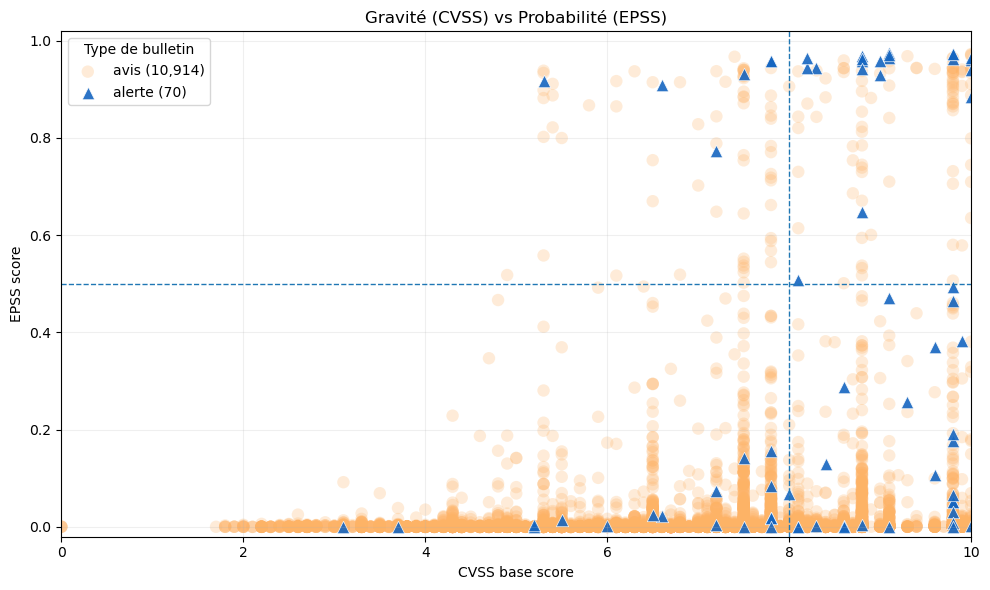

92 CVE urgentes enregistrées → /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/outputs/urgences_cve.csv


In [ ]:
plt.figure(figsize=(10, 6))

# Styles
palette = {"avis": "#FDB366", "alerte": "#1565C0"}
markers = {"avis": "o",       "alerte": "^"}
alphas  = {"avis": 0.25,      "alerte": 0.9}
size_pt = 80 

for typ in ("avis", "alerte"):
    sub = df_unique_scores[df_unique_scores["type"] == typ]
    plt.scatter(
        sub["cvss_score"], sub["epss_score"],
        s=size_pt,
        c=palette[typ],
        marker=markers[typ],
        alpha=alphas[typ],
        edgecolors="white" if typ == "alerte" else "none",
        linewidths=0.5 if typ == "alerte" else 0,
        label=f"{typ} ({len(sub):,})"
    )

# Seuils critiques
plt.axvline(8, linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)")
plt.xlim(0, 10)
plt.ylim(-0.02, 1.02)
plt.legend(title="Type de bulletin")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Export des CVE urgentes
urg = df_unique_all[
    (df_unique_all["cvss_score"] >= 8) &
    (df_unique_all["epss_score"] >= 0.5)
]
urg.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urg):,} CVE urgentes enregistrées → {OUTPUT_DIR/'urgences_cve.csv'}")

Tout d'abord, on retrouve au niveau du positionnement des avis la même dynamique que dans les histogrammes faits durant la phase d'exploraton. En effet, la majorité d'entre eux sont dispersés sur toute la gamme de CVSS (2–10), mais la densité la plus forte se trouve autour de CVSS 7–8 avec EPSS très bas (< 0.2).

Dans la zone "critique" (en haut à droite), on y trouve une poignée d’avis (par rapport au nombre total représenté) et presque toutes les alertes. Ce sont les vraies urgences où l’impact technique ET la probabilité d’attaque sont élevés, ce qui est cohérent avec nos observations antérieures.

Ainsi, le principal message qui ressort de la visualisation est qu'il est important de ne pas s'alarmer systématiquement dès qu’un CVSS arrive à 9 car si l’EPSS est quasi nulle, l’urgence opérationnelle est limitée.
Aussi notre fenêtre critique pourrait constituer notre étiquette positive idéale pour entraîner un classifieur binaire à prédire cette criticité à partir des seules features CVSS, EPSS, days_open, n_cve_refs, vendor_std, etc.

### Violin plot EPSS par quartile CVSS

On cherche ici à savoir si les vulnérabilités les plus graves (CVSS élevé) sont aussi les plus susceptibles d’être exploitées (EPSS élevé). Cette visualisation permet donc de voir la densité des valeurs EPSS dans chaque groupe CVSS (Q1 à Q4), et d’observer leur dispersion, asymétrie, et tendance centrale.

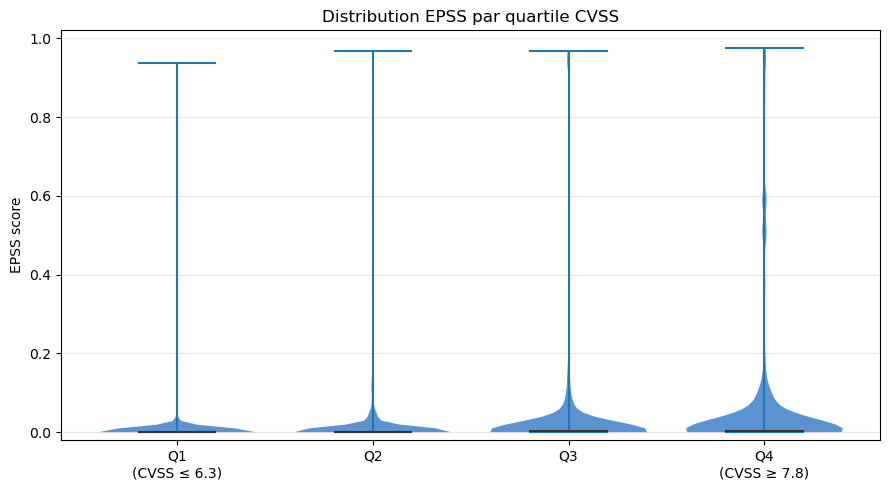

In [529]:
d = df_clean.copy()

# Quartiles
d["cvss_quartile"] = pd.qcut(
    d["cvss_score"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

# Liste des séries EPSS par quartile
grouped_epss = [
    d.loc[d["cvss_quartile"] == q, "epss_score"]
    for q in ["Q1", "Q2", "Q3", "Q4"]
]

# Plot
plt.figure(figsize=(9, 5))
parts = plt.violinplot(
    grouped_epss,
    showmeans=False,
    showmedians=True,
    widths=0.8
)

for pc in parts["bodies"]:
    pc.set_facecolor("#1565C0")
    pc.set_alpha(0.7)

parts["cmedians"].set_color("#333333")

q25 = d["cvss_score"].quantile(0.25)
q75 = d["cvss_score"].quantile(0.75)
quartile_labels = [
    f"Q1\n(CVSS ≤ {q25:.1f})",
    "Q2",
    "Q3",
    f"Q4\n(CVSS ≥ {q75:.1f})",
]

plt.xticks([1, 2, 3, 4], quartile_labels)
plt.ylabel("EPSS score")
plt.title("Distribution EPSS par quartile CVSS")
plt.ylim(-0.02, 1.02)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Dans les quartiles bas (Q1–Q3), les densités sont très concentrées près de zéro : la quasi-totalité des failles de CVSS ≤ 7,8 ont une EPSS très faible, allant jusqu'à maximum 0,2. Cela montre que les failles de gravité faible à moyenne sont rarement exploitables.

En revanche, dans le quartile élevé (Q4, CVSS ≥ 7,8), la distribution s’élargit car on voit une petite épaisseur autour de 0,6 et entre 0,9 et 1,0, signe que parmi les failles très graves, une part d'entre elles sont également très exploitables. Bien entendu la majorité de la distribution reste proche de 0 mais la queue haute est légèrement plus marquée qu’en Q1–Q3.

Ce constat s'aligne avec ceux de la visualisation précédente et suggère que dans le cas d'un clustering, on pourrait d’emblée isoler le cluster Q4 avec EPSS élevé pour le traiter différemment (alerting prioritaire), et réserver un traitement secondaire aux clusters Q1–Q3.

### Histogramme empilé des scores CVSS

On cherche ici à analyser la distribution des niveaux de gravité CVSS (Common Vulnerability Scoring System) des vulnérabilités documentées dans les bulletins avis et alertes de l’ANSSI. On peut ainsi visualiser les plages de gravité les plus fréquentes et identifier les zones critiques (CVSS ≥ 7, 8 ou 9), souvent associées à des failles exploitables ou très graves.

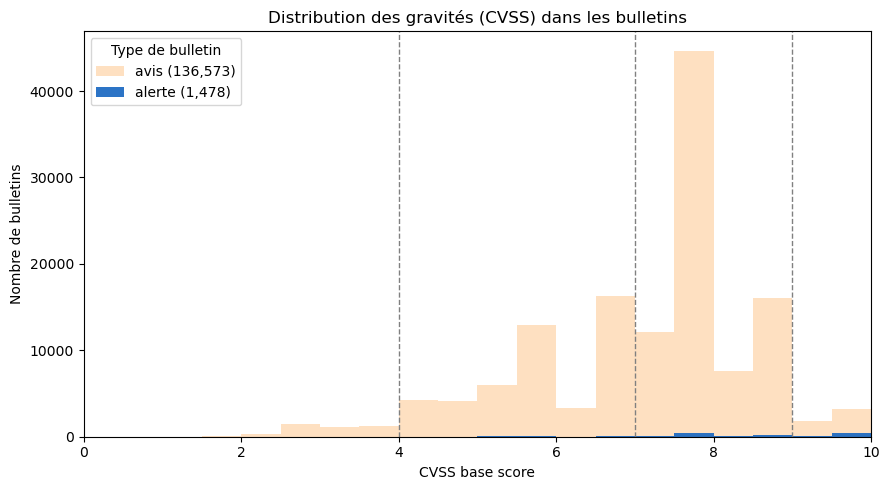

In [530]:
avis_cvss    = df_publi[df_publi["type"] == "avis"]["cvss_score"].dropna()
alertes_cvss = df_publi[df_publi["type"] == "alerte"]["cvss_score"].dropna()

bins = np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9, 5))

# Avis
plt.hist(
    avis_cvss,
    bins=bins,
    color="#FDB366",
    alpha=0.4,
    label=f"avis ({len(avis_cvss):,})",
)

# Alertes
plt.hist(
    alertes_cvss,
    bins=bins,
    color="#1565C0",
    alpha=0.9,
    label=f"alerte ({len(alertes_cvss):,})",
    stacked=True,
)

# Lignes seuils
for x in (4, 7, 9):
    plt.axvline(x, linestyle="--", color="grey", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("Nombre de bulletins")
plt.title("Distribution des gravités (CVSS) dans les bulletins")
plt.xlim(0, 10)
plt.legend(title="Type de bulletin")
plt.tight_layout()
plt.show()

On remarque déjà une concentration très forte des avis autour de CVSS 7,5–8,0 : l’ANSSI publie majoritairement des avis pour des vulnérabilités jugées élevées mais pas forcément urgentes. On voit un second pic bien plus petit en 8,5–9,0 et encore un creux relatif au-delà de 9,0. Les avis pour CVSS < 4 restent marginaux, ce qui est cohérent : on informe moins quand la gravité est faible.

Ensuite, le plus grand nombre d’alertes se situe aussi dans 7,5–8,0, mais proportionnellement aux avis, elles représentent un segment extrêmement restreint. On retrouve une seconde zone d’alerte significative pour CVSS 9,5–10,0, ce sont les vulnérabilités les plus critiques. En revanche, aucune alerte sous CVSS 2,5 : le seuil minimal pour qu’un problème devienne alerte se situe clairement autour de 5–6, et surtout au-delà.

Cette visualisation valide l’idée que CVSS ≥ 9,5 est un signal fort pour déclencher automatiquement une notification email critique, sans traitement manuel.

### Courbe cumulative des vulnérabilités en fonction du temps

On cherche à suivre l’évolution dans le temps du volume total de vulnérabilités recensées par l’ANSSI et comparer les dynamiques des deux types de bulletins (avis et alertes).

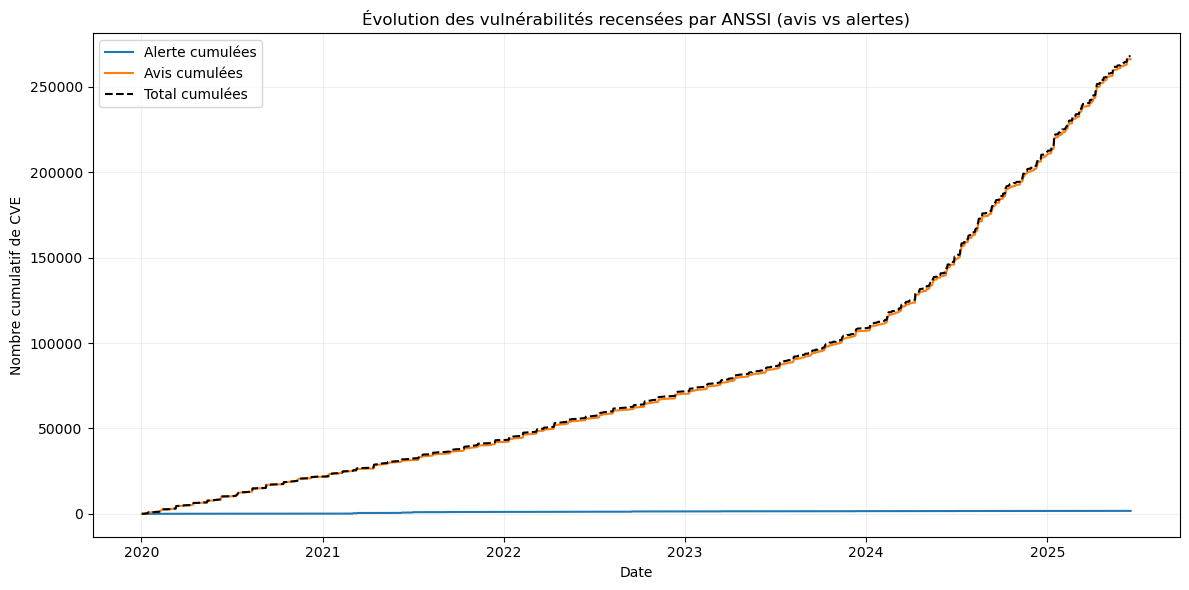

In [ ]:
# On regroupe par date et par type, on compte, on trie, puis on cumule  
vuln_cum_par_type = (
    df_publi
      .groupby(["date", "type"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
      .cumsum()
)

# On calcule aussi le total des vulnérabilités cumulées
vuln_cum_total = (
    df_publi
      .groupby("date")
      .size()
      .sort_index()
      .cumsum()
)

# Tracé
plt.figure(figsize=(12, 6))

# courbes pour chaque type
for bulletin_type in vuln_cum_par_type.columns:
    plt.plot(
        vuln_cum_par_type.index,
        vuln_cum_par_type[bulletin_type],
        label=f"{bulletin_type.capitalize()} cumulées"
    )

# courbe globale
plt.plot(
    vuln_cum_total.index,
    vuln_cum_total.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de CVE")
plt.title("Évolution des vulnérabilités recensées par ANSSI (avis vs alertes)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

On remarque une évolution presque linéaire entre 2020 et 2024 des vulnérabiloités recensées. Toutefois, à partir de 2024, on observe une accentuation de la pente : le nombre de CVE recensées par mois augmente plus rapidement, ce qui indique la hausse de la fréquence des bulletins publiés (déjà visible dans la courbe mensuelle en exploration).

### Stacked Area : Total des vulnérabilités vs subsets "CVSS >= 8 et EPSS >= 0.5"

Nous cherchons ici à suivre mensuellement l’évolution du volume de vulnérabilités, tout en mettant en évidence :
* Les vulnérabilités "dangereuses" (CVSS ≥ 8),
* Les vulnérabilités "urgentes" (EPSS ≥ 0.3),
* Et surtout les vulnérabilités "critiques", cumulant CVSS ≥ 8 et EPSS ≥ 0.3.

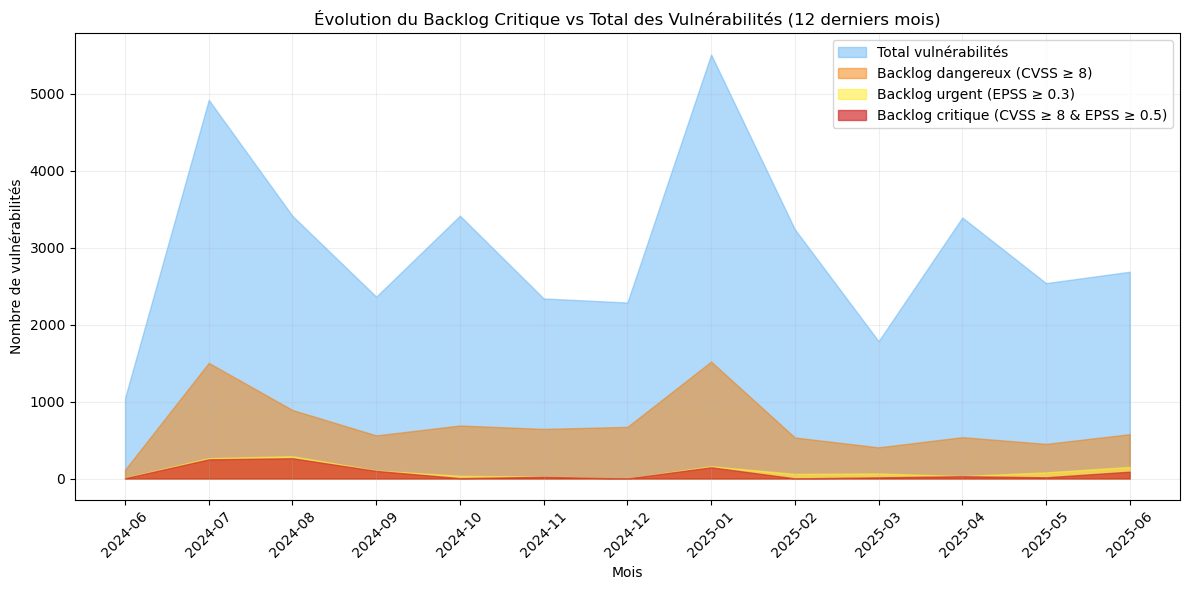


Données mensuelles (12 derniers mois) :
         total  danger  urgent  critical
month                                   
2024-06   1045     114       8         4
2024-07   4918    1502     265       249
2024-08   3411     890     290       263
2024-09   2362     560     104        99
2024-10   3414     689      35         5
2024-11   2339     644      25        22
2024-12   2286     671       2         1
2025-01   5507    1519     159       146
2025-02   3237     533      60         2
2025-03   1784     405      66        15
2025-04   3390     537      32        30
2025-05   2538     450      80        16
2025-06   2686     576     151        89


In [ ]:
# Filtrer les CVE avec des scores valides
df_valid_scores = df_clean.dropna(subset=["cvss_score", "epss_score"]).copy()

# Définir la date limite (12 mois avant aujourd’hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=12)

# Filtrer dans df_valid_scores (CVE dédupliquées)
df_recent = df_valid_scores[df_valid_scores["date"] >= date_limite].copy()

# Regrouper par mois
df_recent["month"] = df_recent["date"].dt.to_period("M")

# Total CVE par mois
monthly_total = df_recent.groupby("month").size()

# Subset dangereux
danger = df_recent[(df_recent["cvss_score"] >= 8)]
monthly_danger = danger.groupby("month").size()

# Subset urgent (EPSS ≥ 0.3)
urgent = df_recent[(df_recent["epss_score"] >= 0.3)]
monthly_urgent = urgent.groupby("month").size()

# Subset critique
critical = df_recent[(df_recent["cvss_score"] >= 8) & (df_recent["epss_score"] >= 0.3)]
monthly_critical = critical.groupby("month").size()


# Aligner les index
all_months = monthly_total.index.union(monthly_critical.index).sort_values()
monthly_total = monthly_total.reindex(all_months, fill_value=0)
monthly_danger = monthly_danger.reindex(all_months, fill_value=0)
monthly_urgent = monthly_urgent.reindex(all_months, fill_value=0)
monthly_critical = monthly_critical.reindex(all_months, fill_value=0)


# Tracé Stacked Area
plt.figure(figsize=(12, 6))
plt.fill_between(all_months.astype(str), monthly_total.values, color="#64B5F6", alpha=0.5, label="Total vulnérabilités")
plt.fill_between(all_months.astype(str), monthly_danger.values, color="#F57C00", alpha=0.5, label="Backlog dangereux (CVSS ≥ 8)")
plt.fill_between(all_months.astype(str), monthly_urgent.values, color="#FFEB3B", alpha=0.6, label="Backlog urgent (EPSS ≥ 0.3)")
plt.fill_between(all_months.astype(str), monthly_critical.values, color="#D32F2F", alpha=0.7, label="Backlog critique (CVSS ≥ 8 & EPSS ≥ 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités (12 derniers mois)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Le nombre total de vulnérabilités recensées oscille entre 1 400 (juin 2024) et plus de 7 200 (janvier 2025). Janvier 2025 et juillet 2024 constituent deux pics majeurs (environ 7 200 et 6 200 CVE), sans doute liés à des vagues de publications massives ou à des mises à jour de nombreux produits.

Les CVE à haute criticité (CVSS ≥ 8) représentent de 10 % à 30 % du total chaque mois. Là aussi, juillet 2024 et janvier 2025 forment des points hauts, traduisant des périodes où un grand nombre de failles critiques sont dévoilées. Même en creux (juin 2024 et mars 2025 par exemple), on reste sur plusieurs centaines de vulnérabilités à traiter mensuellement.

Les failles jugées exploitables (EPSS ≥ 0.3) sont un sous-ensemble plus restreint : typiquement quelques dizaines à quelques centaines par mois. 

Enfin, les CVE cumulant à la fois haute sévérité technique et forte probabilité d’exploitation sont rares : quelques unités à quelques dizaines par mois. Le pic est juillet 2024 (255), suivi d’août 2024 (299). Elles constituent nos urgences absolues et devraient déclencher des alertes email immédiates.

## Analyse des faiblesses (CWE)

### Top 15 des faiblesses (CWE)

On cherche à identifier les CWE les plus fréquemment associées à des CVE et croiser cette fréquence avec la dangerosité potentielle, mesurée par la moyenne du score EPSS.

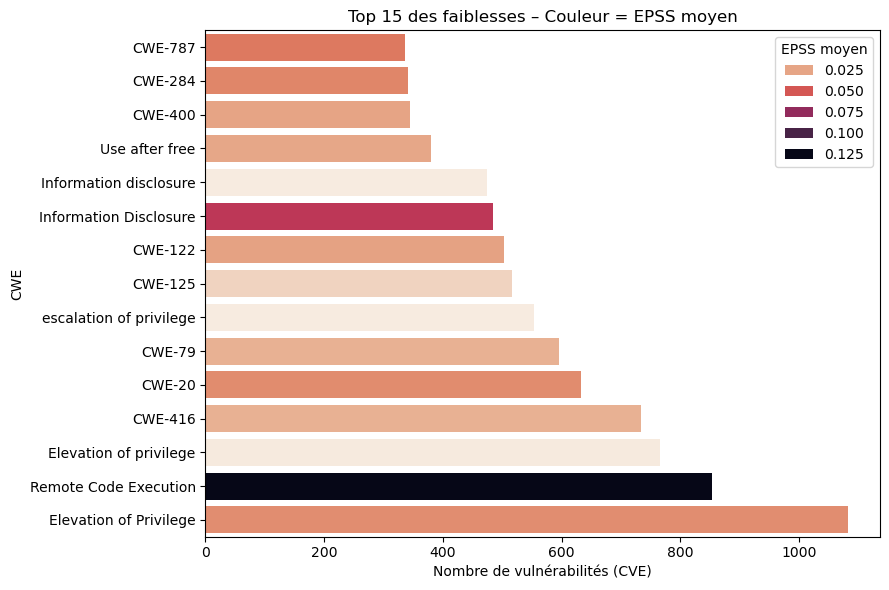

Données du Top 15 des faiblesses (CWE) :
                    cwe   nb  epss_moy
                CWE-787  336  0.039209
                CWE-284  341  0.035065
                CWE-400  345  0.025662
         Use after free  380  0.024491
 Information disclosure  474  0.001094
 Information Disclosure  485  0.060247
                CWE-122  503  0.026076
                CWE-125  516  0.009391
escalation of privilege  554  0.001164
                 CWE-79  595  0.021209
                 CWE-20  633  0.033150
                CWE-416  733  0.021104
 Elevation of privilege  765  0.001878
  Remote Code Execution  854  0.125234
 Elevation of Privilege 1082  0.033086


In [ ]:
# filtrer lignes disposant d’un CWE
d_cwe = df_unique_all.dropna(subset=["cwe"])

# agrégation
top_cwe = (
    d_cwe.groupby("cwe", as_index=False)
         .agg(nb=("cwe", "size"),
              epss_moy=("epss_score", "mean"))
         .sort_values("nb", ascending=False)
         .head(15)
         .sort_values("nb")          
)

# barplot horizontal
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_cwe,
    x="nb",
    y="cwe",
    hue="epss_moy",
    palette="rocket_r",
    dodge=False
)

plt.xlabel("Nombre de vulnérabilités (CVE)")
plt.ylabel("CWE")
plt.title("Top 15 des faiblesses – Couleur = EPSS moyen")
plt.legend(title="EPSS moyen", loc="upper right")
plt.tight_layout()
plt.show()

Les CWEs d’“Elevation of Privilege” et de “Remote Code Execution” dominent largement le classement en nombre de CVE.

C’est aussi pour “Remote Code Execution” que l’EPSS moyen est le plus élevé, soulignant que ces failles sont non seulement nombreuses mais aussi, statistiquement, parmi les plus exploitables en pratique. Les failles de ce type doivent ainsi être surveillées en priorité, car leur haute exploitabilité en fait des cibles de choix pour les attaquants.

À l’autre extrémité, “escalation of privilege” et “Information disclosure” cumulent de très nombreux cas mais présentent des EPSS moyens très bas , ce qui suggère qu’elles sont rarement exploitées en conditions réelles malgré leur prévalence.

Des CWEs comme CWE-20 (input validation) ou Use after free (378 cas) se situent en position médiane : relativement fréquentes et modérément exploitables.

### Courbe de l'évolution de différent CWE au cours du temps

L’objectif de cette visualisation est de suivre la dynamique temporelle des vulnérabilités associées à certaines failles critiques identifiées par leur identifiant CWE. On a pris les 5 plus fréquentes selon la visualisation précédente.

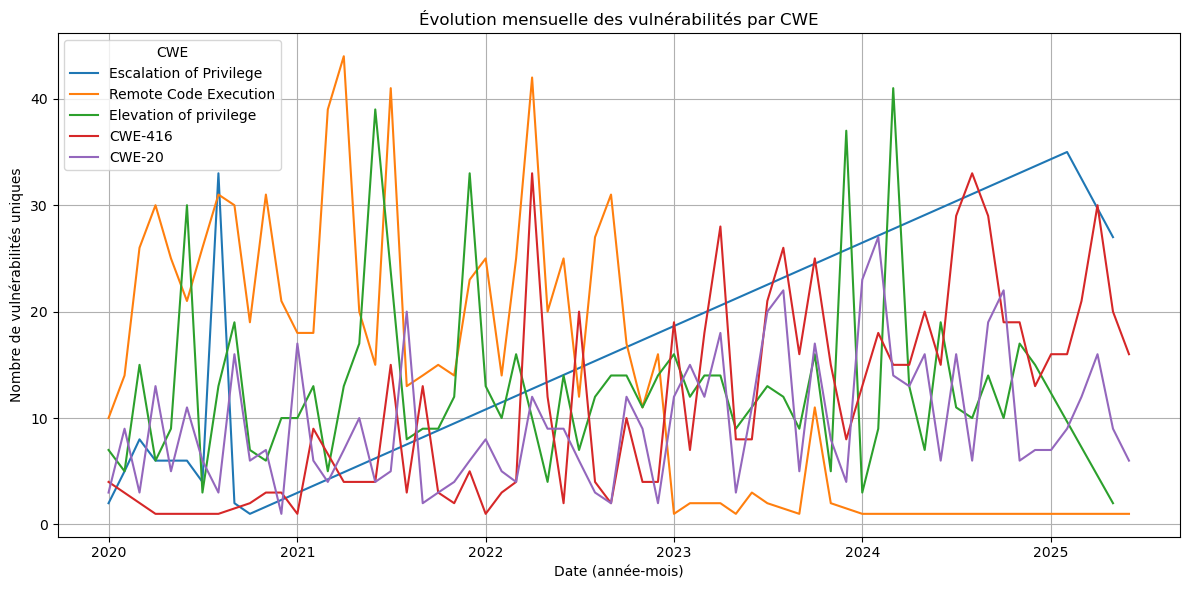

In [534]:
cwe_list = ["Escalation of Privilege", "Remote Code Execution", "Elevation of privilege", "CWE-416", "CWE-20"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df_unique_all[df_unique_all["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l’année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités uniques")
plt.legend(title="CWE")
plt.grid(True)
plt.tight_layout()
plt.show()


Mis à part Escalation of Privilege qui montre globalement une évolution pluôt constante malgré un pic mi-2020, le reste des CWE principales montrent des fluctuations globalement entre 0 et 30 vulnérabilités. 

On remarque entre autres des pics jusqu'à 40 voire plus pour Remote Code Execution en 2021 et 2022. Ces flambées coïncident avec la découverte de failles massivement exploitées comme Log4Shell ou Spring4Shell, où un même pattern de vulnérabilité touche des dizaines de produits à la fois. Ainsi, on voit que RCE demande une surveillance renforcée (alerte à envoyer) dès qu’un pic se dessine.

### Boxplot entre days_open et CWE

On cherche à répondre à la question : Quelles failles mettent le plus de temps à être traitées ?
Le nombre de jours ouverts (days_open) représente le temps entre la publication et la fermeture d'une CVE.

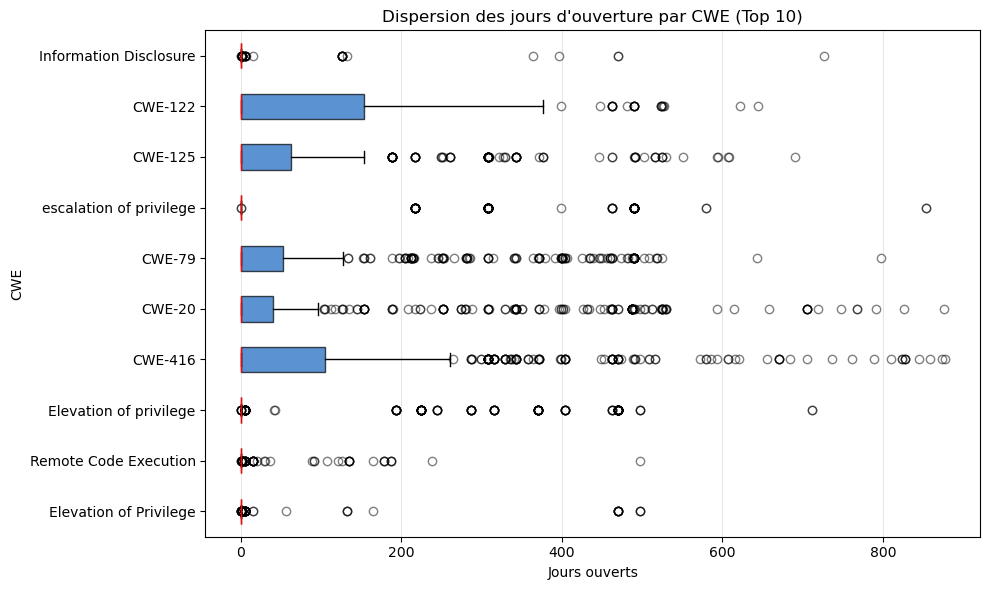

In [ ]:
# Préparation données
df_unique_all["days_open"] = pd.to_numeric(df_unique_all["days_open"], errors="coerce")
df_unique1 = df_unique_all.dropna(subset=["days_open", "cwe"])

# 10 CWE les plus fréquents
top_10_cwe = df_unique_all["cwe"].value_counts().head(10).index.to_list()

# Subset limité au top 10
subset = df_unique1[df_unique1["cwe"].isin(top_10_cwe)].copy()

# Définition de l'ordre
cwe_order = (
  subset["cwe"]
    .value_counts()
    .loc[top_10_cwe]  
    .index
    .tolist()
)

# Tracé
plt.figure(figsize=(10, 6))

plt.boxplot(
  [subset[subset["cwe"] == cwe]["days_open"] for cwe in cwe_order],
  vert=False,  # Boxplot horizontal
  patch_artist=True,  # Remplissage des boîtes
  boxprops=dict(facecolor="#1565C0", alpha=0.7),  # Couleur des boîtes
  medianprops=dict(color="red"),  # Couleur de la médiane
  flierprops=dict(marker="o", color="orange", alpha=0.5),  # Outliers
)

plt.yticks(range(1, len(cwe_order) + 1), cwe_order)
plt.xlabel("Jours ouverts")
plt.ylabel("CWE")
plt.title("Dispersion des jours d'ouverture par CWE (Top 10)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

On remarque que la majorité du temps les failles sont traitées très rapidement. Toutefois, escalation of privilege et CWE-416 (use-after-free) se détachent du lot et montrent une médiane autour de 120–150 jours et un IQR (25–75 %) étendu (jusqu’à 300–500 jours), signe de traitements parfois longs en raison de la complexité des correctifs.

Pour ces mêmes CWE “lourds”, on observe des points isolés jusqu’à 800–900 jours : certaines failles restent ouvertes plus de deux ans, ce qui suggère des blocages (dépendances critiques, problèmes de rétro-compatibilité, absence de correctif viable).

Ainsi, la variable days_open pourrait servir à prioriser les tickets ou alertes dans notre système de notifications mail.

### Histogrammes des principales vulnérabilités sur Apple

Cette visualisation vise à identifier les types de vulnérabilités les plus fréquemment rencontrées chez Apple, en se basant sur les descriptions associées aux CWE.

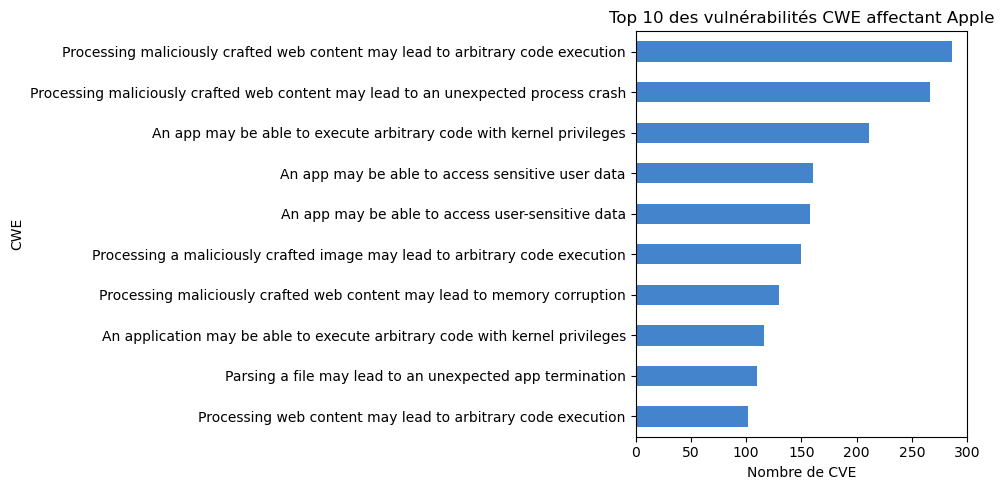

In [ ]:
# Filtrage des lignes où le vendor_std contient "apple" 
df_apple = df_publi[df_publi["vendor_std"].str.contains("apple", case=False, na=False)].copy()

# CWE valide
df_apple = df_apple.dropna(subset=["cwe"])

# Si aucun résultat, on affiche un message
if df_apple.empty:
    print("Aucun CVE avec vendor_std contenant 'apple' trouvé dans le dataset.")
else:
    top_cwe_apple = df_apple["cwe"].value_counts().head(10)

    # Affichage
    plt.figure(figsize=(10, 5))
    top_cwe_apple.plot(kind="barh", color="#1565C0", alpha=0.8)
    plt.title("Top 10 des vulnérabilités CWE affectant Apple")
    plt.xlabel("Nombre de CVE")
    plt.ylabel("CWE")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

Les deux plus gros bars indiquent que la plupart des CVE Apple concernent Safari :
* « Processing maliciously crafted web content may lead to an unexpected process crash » (~280 CVE)
* « … arbitrary code execution » (~250 CVE)
Cela montre que l’analyse et le rendu HTML/CSS/JavaScript constituent un vecteur d’attaque majeur pour la plateforme Apple.

Aussi, « An app may be able to execute arbitrary code with kernel privileges » révèle des vulnérabilités dans des composants plus bas niveau, critiques car elles permettent à une application malicieuse d’échapper complètement au sandbox.

## Analyse par éditeur / fournisseur

### Histogramme des vendeurs les plus affectés par CVE distincts

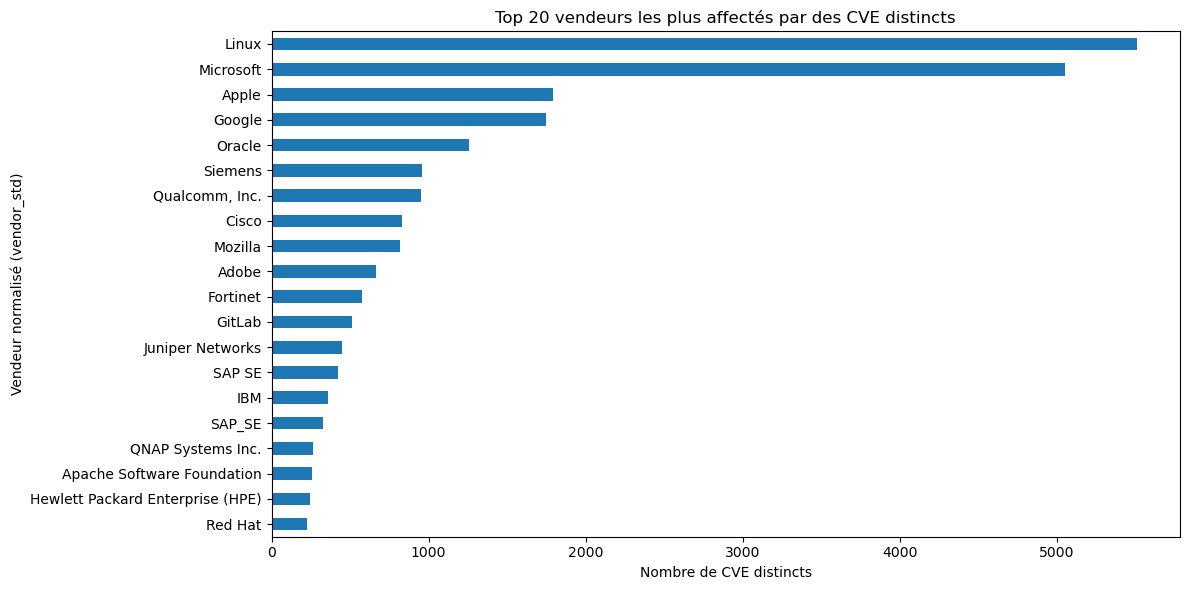

In [ ]:
# Filtre lignes avec vendor_std et cve valides
df_cve = df_publi.dropna(subset=["vendor_std", "cve"]).copy()

# Compte nb CVE distincts par vendor_std
cve_par_vendor = (
    df_cve.groupby("vendor_std")["cve"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12, 6))
cve_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CVE distincts")
plt.xlabel("Nombre de CVE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Le noyau Linux et son écosystème (distributions, modules, pilotes) concentrent le plus grand nombre de vulnérabilités recensées. C’est cohérent avec la large surface d’attaque et la diversité des versions/support.
Windows et la vaste gamme de produits Microsoft (Exchange, Office, Azure…) arrivent en deuxième position : un éditeur incontournable, donc une cible majeure pour les chercheurs et attaquants.
Suivent deux géants historiquement moins vulnérables que Microsoft, mais qui voient tout de même des milliers de failles (Chrome, Android, macOS, iOS…).

On pourrait ainsi proposer des flux d’alertes dédiés selon les éditeurs critiques pour chaque organisation. De plus, il faudrait cibler prioritairement la veille et les alertes sur les environnements Linux et Microsoft, où le volume de CVE est le plus élevé.

### Histogramme des vendeurs les plus affectés par CWE distincts

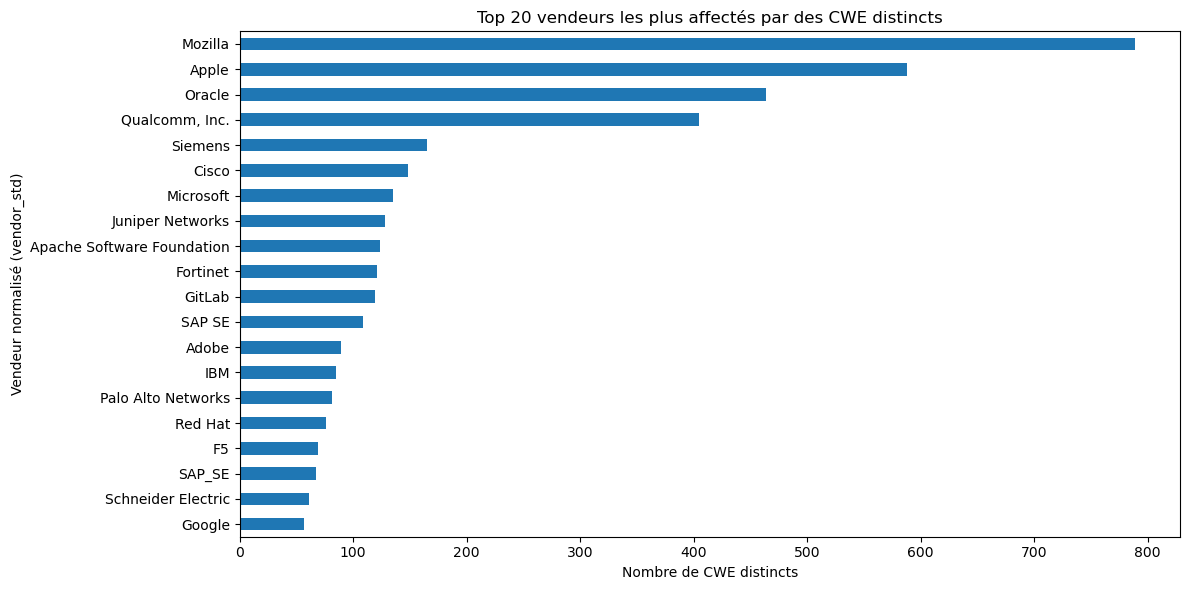

In [ ]:
# Filtre lignes avec vendor_std et cwe valides
df_cwe = df_publi.dropna(subset=["vendor_std", "cwe"]).copy()

# Compte du nombre de CWE distincts par vendor_std
cwe_par_vendor = (
    df_cwe.groupby("vendor_std")["cwe"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12, 6))
cwe_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CWE distincts")
plt.xlabel("Nombre de CWE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Bien que Mozilla n’était pas en tête du nombre total de CVE, c’est l’éditeur dont les vulnérabilités couvrent le plus large éventail de CWE : cela traduit une grande hétérogénéité. Apple arrive deuxième, suivi de Oracle (bases de données, Java, middleware) et Qualcomm (firmware, drivers) qui offrent également une palette étendue de types de failles.

Google, bien qu’ayant un volume de CVE élevé (Chrome, Android), reste focalisé sur un spectre plus restreint de faiblesses.

### Histogramme de comparaison CVE totales vs CVE avec CWE

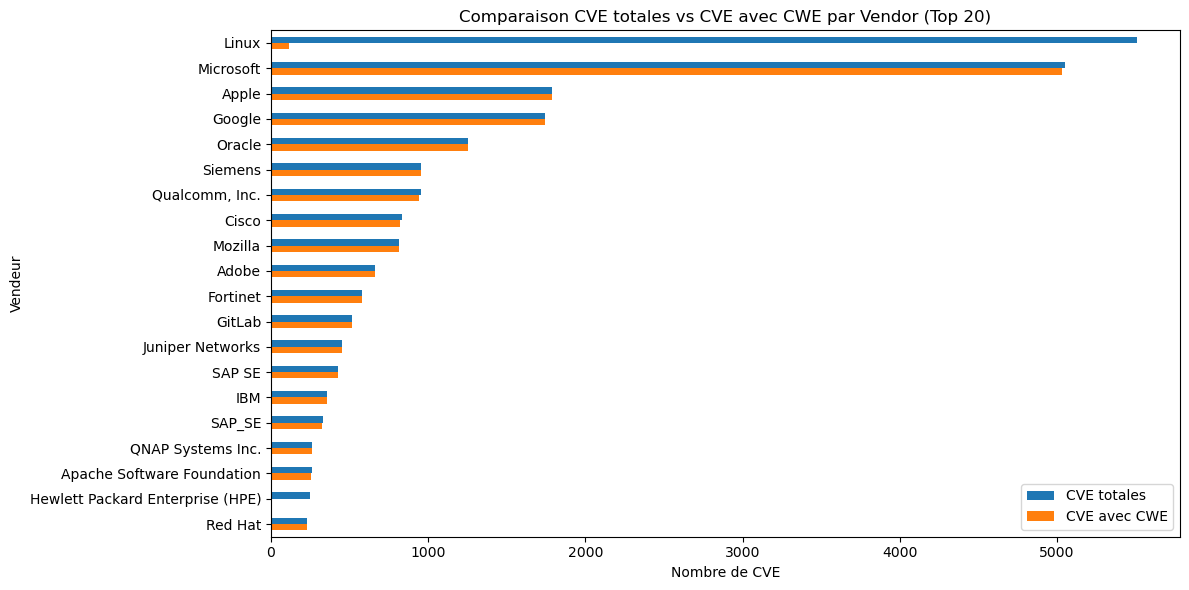

In [ ]:
df_valid = df_publi.dropna(subset=["vendor_std", "cve"]).copy()
cve_par_vendor = df_valid.groupby("vendor_std")["cve"].nunique()
df_with_cwe = df_valid.dropna(subset=["cwe"])
cve_avec_cwe_par_vendor = df_with_cwe.groupby("vendor_std")["cve"].nunique()

df_comparatif = pd.DataFrame({
    "CVE_total": cve_par_vendor,
    "CVE_avec_CWE": cve_avec_cwe_par_vendor
}).fillna(0)

top20 = df_comparatif.sort_values(by="CVE_total", ascending=False).head(20)

top20.plot(kind="barh", figsize=(12, 6))
plt.title("Comparaison CVE totales vs CVE avec CWE par Vendor (Top 20)")
plt.xlabel("Nombre de CVE")
plt.ylabel("Vendeur")
plt.gca().invert_yaxis()
plt.legend(["CVE totales", "CVE avec CWE"])
plt.tight_layout()
plt.show()


Cette visualisation nous permet essentiellement de comprendre pourquoi Linux n'est pas présent dans l'histogramme par CWE alors qu'il est en tête pour les CVE distincts : très peu de CVE sont associées à un CWE ce qui limite notre capacité de compréhension concernant ses failles. Cette observation est perturbante car ne s'aligne pas du tout avec la tendance des autres éditeurs pour lesquels la quasi totalité des CVE ont un CWE associé.

### Boxplot des scores CVSS par éditeur (Top 10)

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 900x600 with 0 Axes>

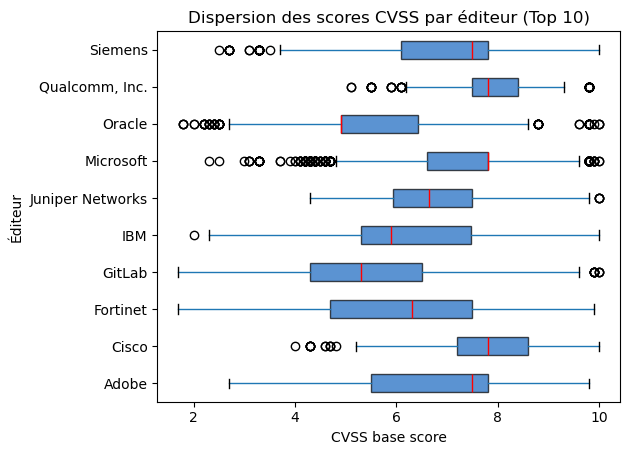

In [ ]:
# On garde uniquement lignes avec cvss_score
df_vendors = (
    df_unique_all
      .dropna(subset=["cvss_score"])
      .copy()
)

# Top 10 vendors en nombre de CVE
top_vendors = df_vendors["vendor_std"].value_counts().head(10).index

subset_top_vendors = df_vendors[df_vendors["vendor_std"].isin(top_vendors)]

plt.figure(figsize=(9, 6))
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor_std",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False,
)
plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # supprime le titre automatique
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()


Sur cette représentation on retrouve des diagrammes moustache avec : la médiane des scores CVSS en rouge, les 1er et 3ème quartiles, et les "outliers" en noir. 

Plus précisemment ceci nous permet d'évaluer quel est le niveau de vulnérabilité le plus commun pour les éditeurs concernés. Fortinet par exemple a une médiane aux alentours de **6** et un 1er et 3ème quartile vers **5 et 7**. Fortinet peut donc s'attendre à subire des vulnérabilités dans cette intervalle à l'avenir. 

### Heat-map associant aux Top 10 des éditeurs, le nombre de CVE produit, pour les CWE les plus fréquents

Cette visualisation permet de vérifier si les CWE les plus fréquents sont influencés par les éditeurs les plus touchés et si ils sont communs à plusieurs éditeurs.

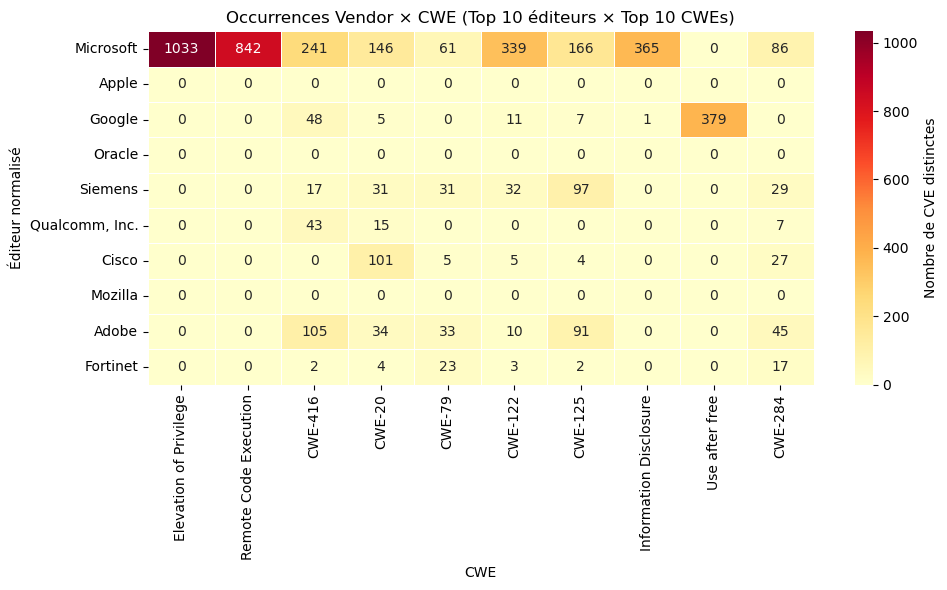

In [ ]:
# partir de df_unique_all + dropna sur vendor_std et cwe
df_vc = (
    df_unique_all
      .dropna(subset=["vendor_std", "cwe"])
      .copy()
)

# top 10 vendors & top 10 CWE
top_vendors = df_vc["vendor_std"].value_counts().head(10).index
top_cwes    = df_vc["cwe"].value_counts().head(10).index

# sous-ensemble raisonnable
sub = df_vc[
    df_vc["vendor_std"].isin(top_vendors) &
    df_vc["cwe"].isin(top_cwes)
]

# matrice Vendor_std × CWE
pivot = (
    sub
      .groupby(["vendor_std", "cwe"])
      .size()
      .unstack(fill_value=0)
)

# forcer l’ordre des lignes & colonnes
pivot = pivot.reindex(index=top_vendors, columns=top_cwes, fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True, fmt="d", linewidths=.5,
    cmap="YlOrRd", cbar_kws={"label": "Nombre de CVE distinctes"}
)
plt.title("Occurrences Vendor × CWE (Top 10 éditeurs × Top 10 CWEs)")
plt.xlabel("CWE")
plt.ylabel("Éditeur normalisé")
plt.tight_layout()
plt.show()


Grâce à cette Heat Map, nous remarquons que les CWE les plus fréquents touchent surtout Microsoft, attestant de l'impact de cet éditeur dans la répartitions des CWE les plus fréquents. Il faut donc prendre en compte cette omniprésence, lorsqu'on évalue quels sont les CWE les plus fréquents

### Histogramme du Top 3 des vulnérabilités CWE pour les 10 principaux vendeurs

Cette représentation permet de mettre en évidence quelles menaces sont les plus fréquentes pour les éditeurs les plus touchés de manière générale, afin de déterminer de quels CWE ils devraient se méfier

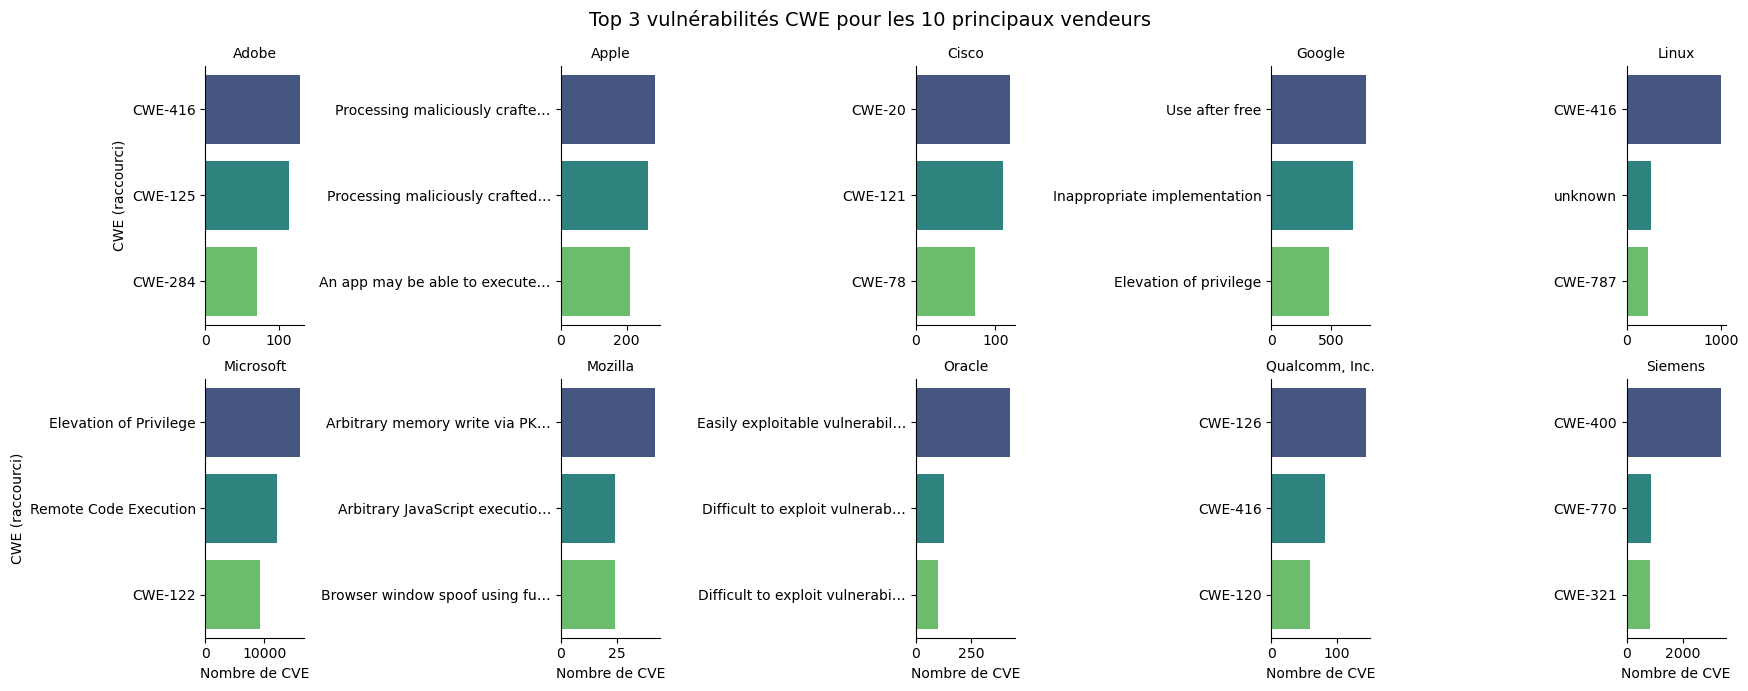

In [ ]:
# top-10 vendeurs
top_10_vendors = (
    df_publi.dropna(subset=["vendor_std", "cve"])
      .groupby("vendor_std")["cve"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index
)

# lignes pertinentes
df_cwe_vendors = (
    df_publi[df_publi["vendor_std"].isin(top_10_vendors)]
      .dropna(subset=["cwe"])
)

# compte des CWE par vendeur
cwe_counts = (
    df_cwe_vendors
    .groupby(["vendor_std", "cwe"])
    .size()
    .reset_index(name="count")
)

# top-3 CWE par vendeur
top_cwes_per_vendor = (
    cwe_counts
    .sort_values(["vendor_std", "count"], ascending=[True, False])
    .groupby("vendor_std")
    .head(3)
)

# création d'un label court mais unique
MAX_LEN = 30     

def make_unique_short(series, max_len=MAX_LEN):
    used = set()
    short_list = []
    for full in series:
        # longueur courante que l'on peut faire évoluer
        cur_len = min(max_len, len(full))
        while True:
            short = full if len(full) <= cur_len else full[:cur_len-1] + "…"
            if short not in used:
                used.add(short)
                short_list.append(short)
                break
            # doublon → on révèle 1 caractère de plus
            if cur_len < len(full):
                cur_len += 1
            else:           # le nom entier est identique : on ne peut pas faire mieux
                # (cela ne devrait jamais arriver sauf si deux CWE identiques)
                short += " "  # force la différence
                used.add(short)
                short_list.append(short)
                break
    return short_list

top_cwes_per_vendor["cwe_short"] = (
    top_cwes_per_vendor
        .groupby("vendor_std")["cwe"]
        .transform(make_unique_short)
)

g = sns.FacetGrid(
    top_cwes_per_vendor,
    col="vendor_std",
    col_wrap=5,
    height=3.5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.barplot, y="cwe_short", x="count", palette="viridis")

g.set_titles("{col_name}")
g.set_axis_labels("Nombre de CVE", "CWE (raccourci)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 3 vulnérabilités CWE pour les 10 principaux vendeurs", fontsize=14)
plt.show()


Ici on observe plusieurs types de profils : 

- Des entreprises qui souffrent, en quantité similaire, de leurs trois CWE les plus fréquents, comme Apple, Cisco ou Google

- Des éditeurs ayant une quantité disproportionnée de CVE pour un type de CWE, comme Linux ou Siemens souffrant respectivement de vulnérabilité CWE-416 et CWE-400

### Courbe comparant l'évolution du nombre de CVE / an pour les 5 éditeurs majeurs

Cette visualisation nous permet de vérifier si des tendances sont présentes dans le traitement et la production de bulletins CVE

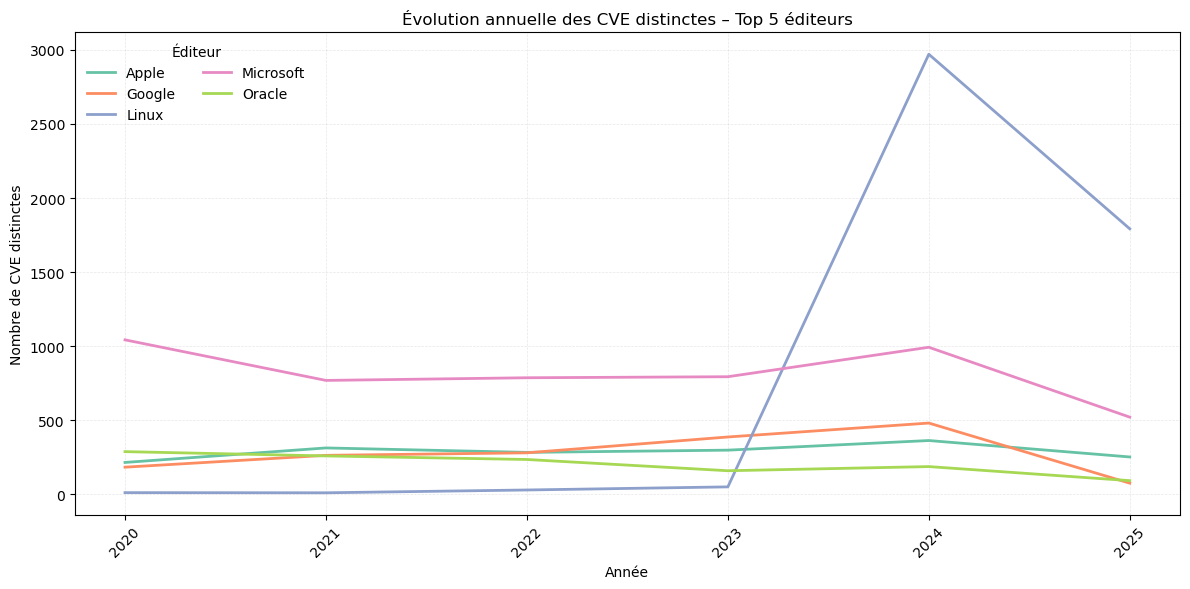

In [ ]:
# une ligne par CVE
df_unique_all = (
    df_publi
      .sort_values("date")
      .drop_duplicates(subset=["cve"])
      .copy()
)

# on ne garde que les CVE avec vendor_std & date
clean = (
    df_unique_all
      .dropna(subset=["vendor_std", "date", "cve"])
      .assign(year=lambda d: d["date"].dt.year)
      .drop_duplicates(subset=["vendor_std", "cve"])  # une seule ligne par paire
)

top5 = clean["vendor_std"].value_counts().head(5).index

# Comptage annuel par vendor_std
pivot = (
    clean[clean["vendor_std"].isin(top5)]
      .groupby(["year", "vendor_std"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Remplir les années manquantes
full_years = pd.RangeIndex(pivot.index.min(), pivot.index.max() + 1)
pivot = pivot.reindex(full_years, fill_value=0)

plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=len(top5))

for i, vendor in enumerate(pivot.columns):
    plt.plot(
        pivot.index,
        pivot[vendor],
        label=vendor,
        color=palette[i],
        linewidth=2
    )

plt.title("Évolution annuelle des CVE distinctes – Top 5 éditeurs")
plt.xlabel("Année")
plt.ylabel("Nombre de CVE distinctes")
plt.xticks(pivot.index, rotation=45)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.legend(title="Éditeur", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


Nous remarquons que les éditeurs Apple, Oracle et Google ont une quantité de CVE attribué beaucoup moins importante que Microsoft ou Linux qui, pour ce dernier, atteint un pic à **3000** CVE en 2024, survolant les autres éditeurs et pouvant attester d'un phénomène exceptionnel, lié à une période de vulnérabilité forte ou d'un changement de politique dans le traitement des vulnérabilités

## Analyse des bulletins et médiatisation

### Treemap des Bulletins, classé par type, date et nombre de produits affectés :

L'objectif de cette représentation est de dénicher les bulletins avec un impact "massifs", parfois sous-estimés, à travers l'évaluation du nombre de produits touchés par une vulnérabilité.

In [ ]:
df = df_publi.copy()
date_limite = pd.Timestamp.now() - pd.DateOffset(months=4)

# Nb produits distincts par bulletin
df["n_affected_products"] = (
    df.groupby("id_anssi")["produit"]
      .transform("nunique")
)

# 1 ligne par bulletin
bulletins = (
    df[["type", "id_anssi", "date", "titre", "n_affected_products", "cvss_score", "epss_score"]]
      .drop_duplicates(subset=["id_anssi"])
)

# Top 200 bulletins les plus impactants
top200 = bulletins.nlargest(200, "n_affected_products")
recent = top200[top200["date"] >= date_limite]

treemap_data = (
    recent
      .sort_values("n_affected_products", ascending=False)
      .reset_index(drop=True)
)

mid = np.average(
    treemap_data["n_affected_products"],
    weights=treemap_data["n_affected_products"]
)

fig = px.treemap(
    treemap_data,
    path=["type", "date", "id_anssi", "titre"],
    values="n_affected_products",
    color="n_affected_products",
    color_continuous_scale="RdBu",
    color_continuous_midpoint=mid,
    title="Treemap des bulletins récents – impact (n° produits affectés)"
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

# Trouver le bulletin avec le plus grand nombre de produits affectés
bulletin_max_impact = treemap_data.loc[treemap_data['n_affected_products'].idxmax()]

# Afficher les informations du bulletin de manière plus lisible
print("Bulletin avec le plus grand impact :")
print(f"Type : {bulletin_max_impact['type']}")
print(f"ID ANSSI : {bulletin_max_impact['id_anssi']}")
print(f"Date : {bulletin_max_impact['date'].strftime('%Y-%m-%d')}")
print(f"Titre : {bulletin_max_impact['titre']}")
print(f"Nombre de produits affectés : {bulletin_max_impact['n_affected_products']}")
print(f"Score CVSS : {bulletin_max_impact['cvss_score'] if not pd.isna(bulletin_max_impact['cvss_score']) else 'Non disponible'}")
print(f"Score EPSS : {bulletin_max_impact['epss_score'] if not pd.isna(bulletin_max_impact['epss_score']) else 'Non disponible'}")

Bulletin avec le plus grand impact :
Type : avis
ID ANSSI : CERTFR-2025-AVI-0284
Date : 2025-04-08
Titre : Multiples vulnérabilités dans les produits Siemens
Nombre de produits affectés : 156
Score CVSS : 9.8
Score EPSS : 0.00217


Cette représentation permet de mettre en évidence les bulletins qui ont un impact large, créant un nouveau moyen de cibler les vulnérabilités à traiter.

Ici, nous observons par exemple que, sur les 4 derniers mois, le bulletin CERTFR-2025-AVI-0284, est le bulletin impactant le plus de produit. Cependant, en cherchant les détails de cet avis, nous remarquons que si son score CVSS est élevée, son score EPSS est bas. Ce bulletin aurait donc pu passer "sous le radar" puisque les mesures de son urgence sont faibles, bien que son impact soit probablement important.

###  

### Nuage de point (scatter), Nombre de références x Score EPSS :

L'étude de la relation entre le nombre de références d'un bulletin et son score EPSS nous permet de mettre en perspective le rôle de la popularité/médiatisation d'un bulletin dans l'évaluation de l'urgence de traitement. L'hypothèse soulevée est que : plus de sources implique un risque médiatique et une exploitation probable.

Nous utilisons un tableau complémentaire pour évaluer des points d'intérêts (nombre de références élevé), selon leur niveau de danger et d'urgence de traitement.

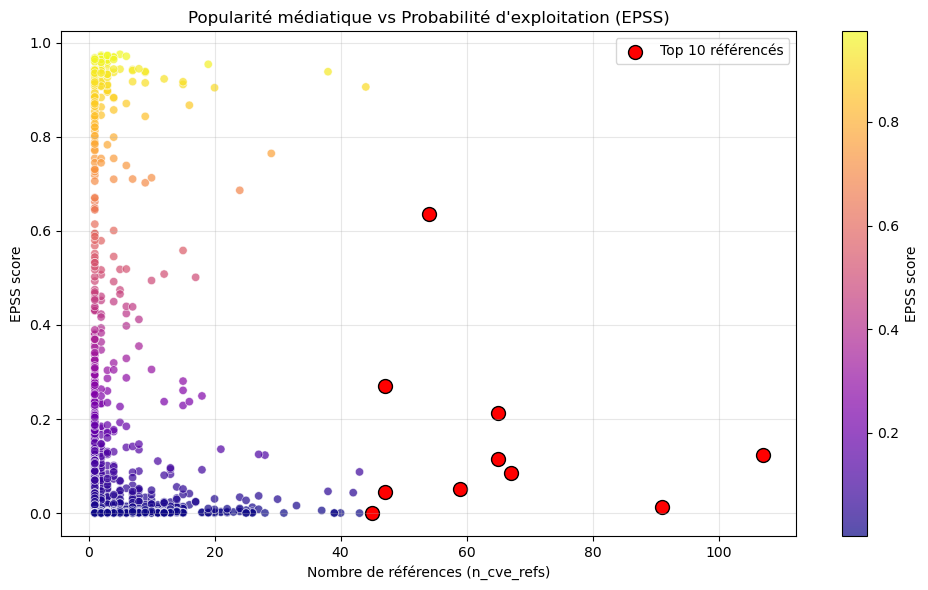

🔝 Top 10 des CVE les plus référencées :
╒════════╤════════════════╤══════════════╤══════════════╤══════════════╤════════════╕
│        │ cve            │   n_cve_refs │   epss_score │   cvss_score │ cvss_sev   │
╞════════╪════════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ 226906 │ CVE-2021-28165 │          107 │        0.123 │        7.500 │ HIGH       │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 237644 │ CVE-2021-21295 │           91 │        0.013 │        5.900 │ MEDIUM     │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 263640 │ CVE-2019-9514  │           67 │        0.086 │        7.500 │ HIGH       │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 263643 │ CVE-2019-9512  │           65 │        0.212 │        7.500 │ HIGH       │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  52997 │ CVE

In [ ]:
df = df_unique_scores.copy()
df = df.dropna(subset=["n_cve_refs", "epss_score"])

# 10 CVE les plus citées
top_referenced = df.nlargest(10, "n_cve_refs")

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df["n_cve_refs"],
    df["epss_score"],
    c=df["epss_score"],
    cmap="plasma",
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

plt.scatter(
    top_referenced["n_cve_refs"],
    top_referenced["epss_score"],
    color="red",
    edgecolors="black",
    s=100,
    label="Top 10 référencés"
)

plt.colorbar(sc, label="EPSS score")
plt.xlabel("Nombre de références (n_cve_refs)")
plt.ylabel("EPSS score")
plt.title("Popularité médiatique vs Probabilité d'exploitation (EPSS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau des top 10
print("Top 10 des CVE les plus référencées :")
print(tabulate(
    top_referenced[["cve", "n_cve_refs", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid",
    floatfmt=".3f"
))

Le graphe que nous obtenons met en évidence une tendance : es bulletins avec un nombre de références élevés sont pour la plupart dotés d'un score EPSS faible. En effet, on constate sur notre nuage de point que, si quelques bulletins avec un score EPSS élevé ont un nombre de références un peu plus élevé que la moyenne, les bulletins les plus référencés ont un score EPSS faible.

En analysant plus précisément ces points d'intérêts grâce au tableau complémentaire, nous remarquons que, si le score EPSS de ces points est faible, leur sévérité CVSS est variée et peut souvent être élevée comme pour le bulletin, CVE-2024-3094, avec un score CVSS de **10**.

Ce graphique permet de montrer que la popularité/médiatisation d'un bulletin, est un critère à part de l'évaluation des risques. Notre hypothèse n'est donc pas validée par cette visualisation, qui montre peut-être que la popularité et la médiatisation d'un bulletin est sous-estimé par le score EPSS.

###  

### Nuage de point (scatter) comparant, nombre de révisions x Score EPSS :

À travers cette visualisation, on cherche à déterminer si le nombre de révisions d'un bulletin ANSSI permet d'indiquer une autre dimension d'urgence de risque.

Nous utilisons un tableau complémentaire, associé aux points d'intérêts (EPSS modéré x Révisions nombreuses), pour évaluer les risques globaux de ces derniers.

Top 10 des bulletins avec EPSS < 0.5 :
╒═══════╤═════════════════════╤════════════════╤═══════════════╤══════════════╤══════════════╤════════════╕
│       │ id_anssi            │ cve            │   n_revisions │   epss_score │   cvss_score │ cvss_sev   │
╞═══════╪═════════════════════╪════════════════╪═══════════════╪══════════════╪══════════════╪════════════╡
│ 91614 │ CERTFR-2021-ALE-014 │ CVE-2021-34481 │            11 │        0.004 │        8.800 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼────────────┤
│ 91661 │ CERTFR-2021-ALE-014 │ CVE-2021-36958 │            11 │        0.018 │        7.800 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼────────────┤
│ 91941 │ CERTFR-2022-ALE-008 │ CVE-2022-41082 │            10 │        0.067 │        8.000 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼───

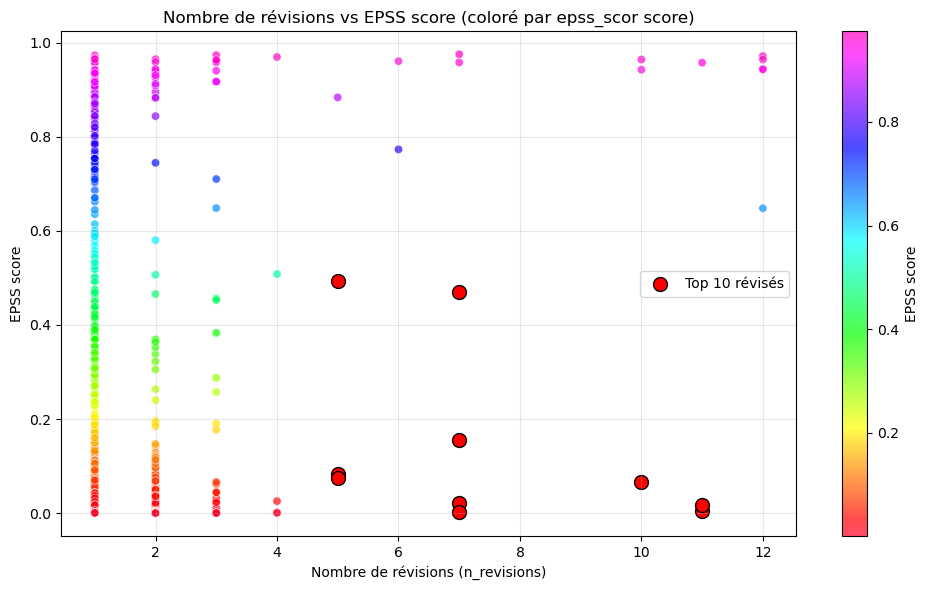

In [ ]:
plt.figure(figsize=(10, 6))

# Filtrer bulletins avec un EPSS inférieur à 0.5
filtered_bulletins = df_unique_scores[df_unique_scores["epss_score"] < 0.5]

# Sélectionner top 10 bulletins par nombre de révisions
top_10_revisions = filtered_bulletins.nlargest(10, "n_revisions")

print("Top 10 des bulletins avec EPSS < 0.5 :")
print(tabulate(
    top_10_revisions[["id_anssi", "cve", "n_revisions", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid",
    floatfmt=".3f"
))

scatter = plt.scatter(
    df_unique_scores["n_revisions"],
    df_unique_scores["epss_score"],
    c=df_unique_scores["epss_score"],  # couleur = CVSS
    cmap="gist_rainbow",
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

plt.scatter(
    top_10_revisions["n_revisions"],
    top_10_revisions["epss_score"],
    c="red",
    edgecolors="black",
    label="Top 10 révisés",
    s=100,
)

plt.colorbar(scatter, label="EPSS score")
plt.xlabel("Nombre de révisions (n_revisions)")
plt.ylabel("EPSS score")
plt.title("Nombre de révisions vs EPSS score (coloré par epss_scor score)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Sur le nuage de points, nous remarquons deux phénomènes :

**1.**  La majorité des bulletins ont nombre de révisions entre 0 et 3.

**2.**  Des bulletins qu'on peut considérer comme "outliers", dépassent ce nombre, certain avec un score EPSS faible (**< 0.5 voir < 0.2**), ont un nombre de révisions plus élevé que la normale, allant jusqu'à **11** pour le cas : CERTFR-2021-ALE-014. Ces cas nous intéressent car, grâce au tableau complémentaire, nous constatons que leur sévérité cvss est élevée voire critique.

Ainsi, prendre en compte le nombre de révisions d'un bulletin peut fournir un outil pour gérer les situations où le traitement du backlog est complexe, où des données de risques sont manquantes.

###   

## Modèles de Machine Learning

### Imports supplémentaires

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Modèle non-supervisé (K-Means)

#### Chargement et prétraitement des données

In [35]:
df = pd.read_csv(DATA_CSV)
print(f"Données: {df.shape[0]} lignes × {df.shape[1]} colonnes")

# Sélection numérique + nettoyage
num = df.select_dtypes(include=[np.number]).dropna()
print(f"Features numériques retenues: {num.shape[1]}, lignes après dropna: {num.shape[0]}")

# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(num)

Données: 264183 lignes × 22 colonnes
Features numériques retenues: 7, lignes après dropna: 89424


#### Évaluation simultanée des indices pour k ∈ [2, 15]

In [36]:
from joblib import Parallel, delayed

def evaluate_one_k(X, k, sample_frac=0.3, random_state=42):
    """Fit KMeans et calcule les métriques sur un échantillon pour silhouette, etc."""
    km = KMeans(
        n_clusters=k,
        random_state=random_state,
        n_init=5,            
        max_iter=200,        
        algorithm='elkan'    
    ).fit(X)
    labels = km.labels_
    inertia = km.inertia_
    
    # Échantillonner pour silhouette/calinski/davies
    idx = np.random.RandomState(random_state).choice(
        len(X), size=int(len(X)*sample_frac), replace=False
    )
    X_samp, lbl_samp = X[idx], labels[idx]
    
    sil = silhouette_score(X_samp, lbl_samp)
    ch  = calinski_harabasz_score(X_samp, lbl_samp)
    db  = davies_bouldin_score(X_samp, lbl_samp)
    
    return {
        'k': k,
        'inertia': inertia,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db
    }

def evaluate_k_range_fast(X, k_min=2, k_max=15, n_jobs=6):
    # Calcul en parallèle
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_one_k)(X, k) for k in range(k_min, k_max + 1)
    )
    df = pd.DataFrame(results).sort_values('k').reset_index(drop=True)
    
    # Méthode du coude
    inertias = df['inertia'].values
    second_deriv = inertias[:-2] - 2 * inertias[1:-1] + inertias[2:]
    elbow_idx = np.argmax(second_deriv) + 1  # +1 décale vers le k central
    elbow_k = df.loc[elbow_idx, 'k']
    
    df['elbow_opt_k'] = elbow_k
    
    return df, elbow_k

metrics_df_fast, k_elbow_fast = evaluate_k_range_fast(X, k_min=2, k_max=15)
print(f"→ K optimal (méthode du coude) = {k_elbow_fast}")
metrics_df_fast


→ K optimal (méthode du coude) = 7


,k,inertia,silhouette,calinski_harabasz,davies_bouldin,elbow_opt_k
0,2,521685.142184,0.243195,5308.675944,1.704816,7
1,3,440786.578765,0.235281,5539.894648,1.438405,7
2,4,375582.133956,0.255505,5852.228231,1.349186,7
3,5,326727.302404,0.262232,6179.619511,1.146156,7
4,6,281785.831879,0.286257,6592.960457,1.115840,7
5,7,238826.791152,0.293738,7188.945522,1.012901,7
6,8,214290.730804,0.266763,7317.786404,0.986310,7
7,9,198168.711555,0.276458,7166.151734,1.060595,7
8,10,184081.244607,0.282773,7068.470074,1.026205,7
9,11,173805.144102,0.293675,6862.861712,1.011243,7


#### Visualisation des métriques et du coude

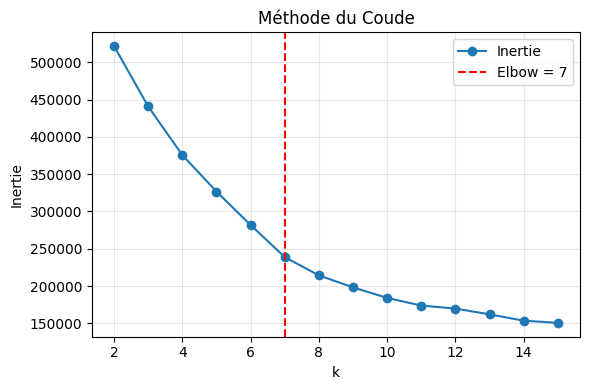

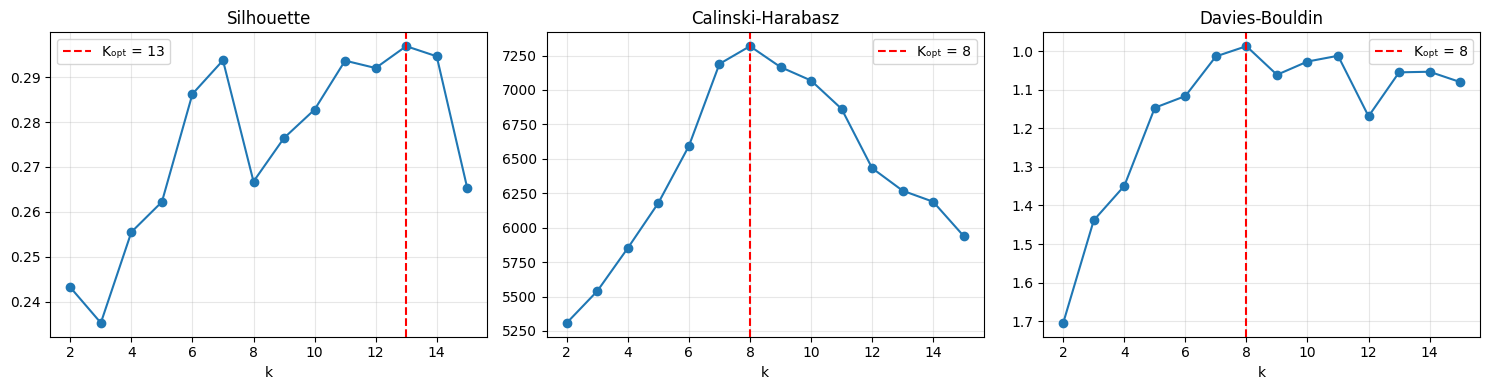

In [37]:
# Calcul k optimaux
k_sil = metrics_df_fast.loc[metrics_df_fast['silhouette'].idxmax(), 'k']
k_ch  = metrics_df_fast.loc[metrics_df_fast['calinski_harabasz'].idxmax(), 'k']
k_db  = metrics_df_fast.loc[metrics_df_fast['davies_bouldin'].idxmin(), 'k']

# Méthode du coude
plt.figure(figsize=(6,4))
plt.plot(metrics_df_fast['k'], metrics_df_fast['inertia'], 'o-', label='Inertie')
plt.axvline(k_elbow_fast, color='red', linestyle='--', label=f'Elbow = {k_elbow_fast}')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Méthode du Coude')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Autres scores avec marquage des k optimaux
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, metric, name, k_opt in zip(
        axes,
        ['silhouette', 'calinski_harabasz', 'davies_bouldin'],
        ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
        [k_sil, k_ch, k_db]
    ):
    ax.plot(metrics_df_fast['k'], metrics_df_fast[metric], 'o-')
    if metric == 'davies_bouldin':
        ax.invert_yaxis()
    ax.axvline(k_opt, color='red', linestyle='--', label=f'Kₒₚₜ = {k_opt}')
    ax.set_xlabel('k')
    ax.set_title(name)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Sélection du k optimal

In [38]:
# Récupération k optimaux par méthode
k_elbow = k_elbow_fast
k_sil    = int(metrics_df_fast.loc[metrics_df_fast['silhouette'].idxmax(), 'k'])
k_ch     = int(metrics_df_fast.loc[metrics_df_fast['calinski_harabasz'].idxmax(), 'k'])
k_db     = int(metrics_df_fast.loc[metrics_df_fast['davies_bouldin'].idxmin(), 'k'])

print("Recommandations par méthode :")
print(f"  • Méthode du coude (inertie)       → k = {k_elbow}")
print(f"  • Coefficient de silhouette        → k = {k_sil}")
print(f"  • Indice Calinski-Harabasz         → k = {k_ch}")
print(f"  • Indice Davies-Bouldin (minimiser)→ k = {k_db}")

# Consensus : le plus fréquent, sinon la médiane
candidates = [k_elbow, k_sil, k_ch, k_db]
from collections import Counter
freq = Counter(candidates)
if len(freq) == 1:
    k_opt = candidates[0]
elif freq.most_common(1)[0][1] > 1:
    k_opt = freq.most_common(1)[0][0]
else:
    k_opt = int(np.median(candidates))

print(f"\nk optimal retenu par consensus = {k_opt}")


Recommandations par méthode :
  • Méthode du coude (inertie)       → k = 7
  • Coefficient de silhouette        → k = 13
  • Indice Calinski-Harabasz         → k = 8
  • Indice Davies-Bouldin (minimiser)→ k = 8

k optimal retenu par consensus = 8


#### Entraînement du modèle final

In [39]:
final_km = KMeans(
    n_clusters=k_opt,
    random_state=42,
    n_init=10,
    algorithm='elkan'
).fit(X)

labels = final_km.labels_

print(f"Modèle entraîné avec k = {k_opt}")
print("→ Inertie finale :", final_km.inertia_)

Modèle entraîné avec k = 8
→ Inertie finale : 214290.7308044581


#### Analyse des clusters

In [40]:
df_clustered = num.copy()  
df_clustered['Cluster'] = labels

# Distribution clusters
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
cluster_distribution = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values
})
cluster_distribution['Percentage'] = (
    cluster_distribution['Count'] / len(df_clustered) * 100
).round(2)
print("Répartition des clusters")
display(cluster_distribution)

# Centroïdes
centroids = (
    df_clustered
    .groupby('Cluster')
    .mean()
    .round(3)
    .reset_index()
)
print("\nCentroïdes (moyennes des features) par cluster")
display(centroids)


Répartition des clusters


,Cluster,Count,Percentage
0,0,23874,26.70
1,1,22357,25.00
2,2,3556,3.98
3,3,2121,2.37
4,4,15661,17.51
5,5,322,0.36
6,6,1313,1.47
7,7,20220,22.61



Centroïdes (moyennes des features) par cluster


,Cluster,n_revisions,cvss_score,n_cve_refs,lag_anssi_days,epss_score,epss_percentile,days_open
0,0,1.087,7.800,1.410,11.434,0.037,0.771,24.664
1,1,1.050,7.544,1.750,26.207,0.001,0.280,79.579
2,2,1.101,7.320,25.309,144.368,0.013,0.452,296.303
3,3,1.288,8.039,4.572,59.085,0.697,0.986,97.273
4,4,1.060,4.861,2.771,84.475,0.002,0.288,108.594
5,5,8.522,8.288,2.053,-2.792,0.533,0.940,148.401
6,6,1.152,6.959,6.734,1296.940,0.016,0.612,105.873
7,7,1.036,7.120,3.148,58.980,0.002,0.271,459.596


#### Visualisation PCA 2D des clusters

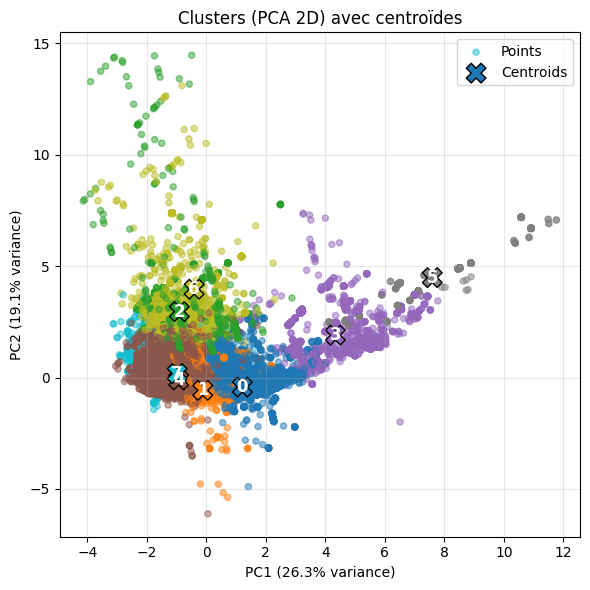

In [41]:
pca = PCA(n_components=2).fit(X)
X2 = pca.transform(X)

# Projection centroïdes
centers_scaled = final_km.cluster_centers_
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1],
            c=labels, cmap='tab10', alpha=0.5, s=20, label='Points')
plt.scatter(centers_pca[:,0], centers_pca[:,1],
            c=range(len(centers_pca)), cmap='tab10', 
            marker='X', s=200, edgecolor='k', label='Centroids')
for i, (x,y) in enumerate(centers_pca):
    plt.text(x, y, str(i), fontsize=12, fontweight='bold',
             ha='center', va='center', color='white')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.title("Clusters (PCA 2D) avec centroïdes")
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Profils de clusters

In [42]:
centroids_df = (
    df_clustered
    .groupby('Cluster')
    .mean()
    .round(3)
    .reset_index()
)

cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
profiles = []

for cid, count in cluster_counts.items():
    pct = count / len(df_clustered) * 100
    centroid_row = centroids_df.loc[centroids_df['Cluster'] == cid].iloc[0].to_dict()
    profile = {
        'Cluster': cid,
        'Count': int(count),
        'Percentage': round(pct, 2)
    }
    for feat, val in centroid_row.items():
        if feat != 'Cluster':
            profile[f"Mean_{feat}"] = val
    profiles.append(profile)

profiles_df = pd.DataFrame(profiles)
display(profiles_df)


,Cluster,Count,Percentage,Mean_n_revisions,Mean_cvss_score,Mean_n_cve_refs,Mean_lag_anssi_days,Mean_epss_score,Mean_epss_percentile,Mean_days_open
0,0,23874,26.70,1.087,7.800,1.410,11.434,0.037,0.771,24.664
1,1,22357,25.00,1.050,7.544,1.750,26.207,0.001,0.280,79.579
2,2,3556,3.98,1.101,7.320,25.309,144.368,0.013,0.452,296.303
3,3,2121,2.37,1.288,8.039,4.572,59.085,0.697,0.986,97.273
4,4,15661,17.51,1.060,4.861,2.771,84.475,0.002,0.288,108.594
5,5,322,0.36,8.522,8.288,2.053,-2.792,0.533,0.940,148.401
6,6,1313,1.47,1.152,6.959,6.734,1296.940,0.016,0.612,105.873
7,7,20220,22.61,1.036,7.120,3.148,58.980,0.002,0.271,459.596


## Machine Leanring supervisé : prédire le score CVSS

### Analyse de corrélation des variables

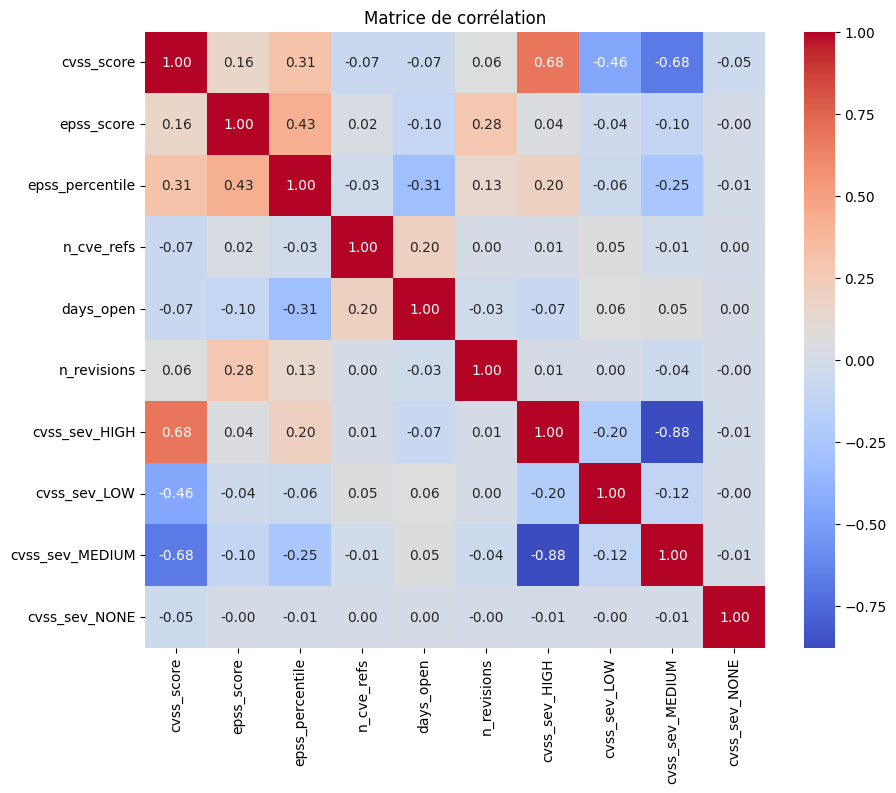

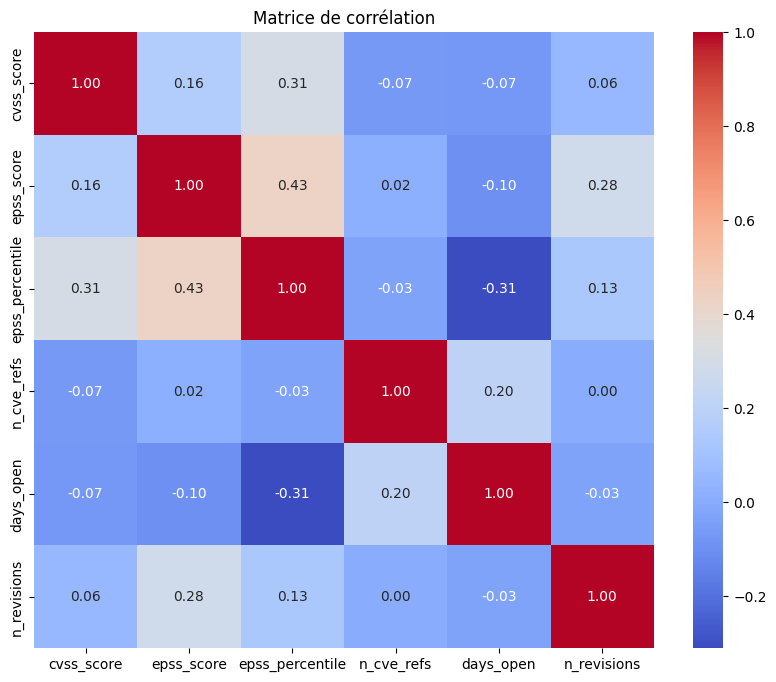

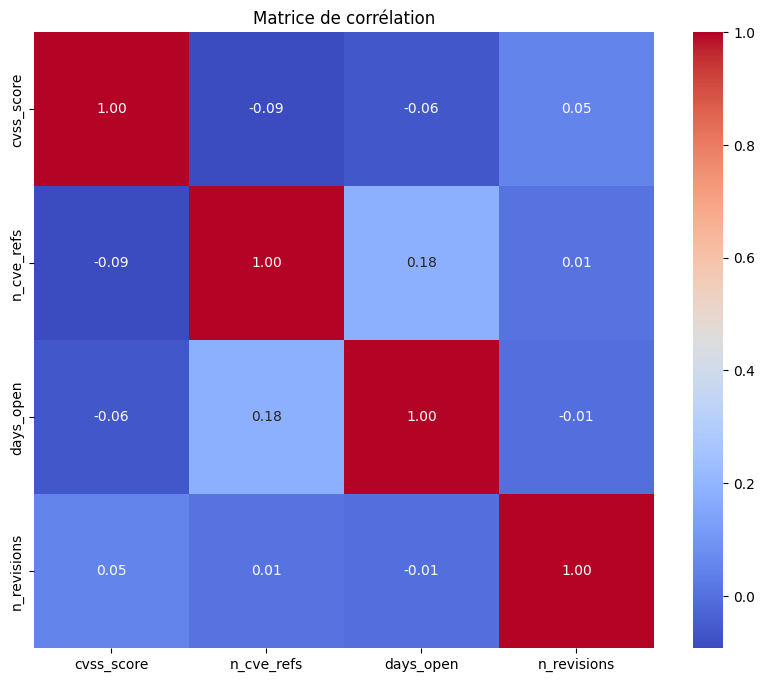

In [43]:

#Sélection des colonnes pertinentes et fortement corrélées
data_heavy = df_full.dropna(subset=["cvss_score","cvss_sev", "epss_score", "epss_percentile","n_cve_refs","days_open", "n_revisions"]).copy()
data_heavy = data_heavy[["cvss_score", "cvss_sev", "epss_score", "epss_percentile", "n_cve_refs", "days_open", "n_revisions"]]
data_heavy = pd.get_dummies(data_heavy, drop_first=True)
# Calculer la matrice de corrélation
correlation_matrix = data_heavy.corr()

# Afficher la matrice de corrélation avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

#Sélection de colonnes pertinentes et moyennement corrélées
data_mid = df_full.dropna(subset=["cvss_score", "epss_score", "epss_percentile","n_cve_refs","days_open", "n_revisions"]).copy()
data_mid = data_mid[["cvss_score", "epss_score", "epss_percentile", "n_cve_refs", "days_open", "n_revisions"]]
data_mid = pd.get_dummies(data_mid, drop_first=True)
# Calculer la matrice de corrélation
correlation_matrix = data_mid.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

 # Supprimer les lignes avec des valeurs manquantes dans les colonnes nécessaires
X = df_full.dropna(subset=["cvss_score", "n_cve_refs","days_open", "n_revisions"]).copy()
# Garder uniquement les colonnes nécessaires
X = X[["cvss_score", "n_cve_refs", "days_open","n_revisions"]]
# Convertir les colonnes catégoriques en numériques
X = pd.get_dummies(X, drop_first=True)


correlation_matrix = X.corr()

# Afficher la matrice de corrélation avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

Dans la première matrice de corrélation, associant des variables censé être corrélés au score CVSS, on observe assez logiquement que des variables comme le score EPSS et le pourcentage EPSS sont fortement corrélées entre elles (proche de 1 ou -1), et que les sévérité CVSS sont corrélés avec le score CVSS. 

Dans la deuxième, éliminant la sévérité CVSS, on remarque plus facilement que le nombre de jours d'ouverture d'un bulletin est corrélé avec le pourcentage EPSS.

Finalement, la dernière matrice de corrélation regroupe les variables les moins corrélées entre elles. C'est ces variables que nous utiliserons pour prédire le score CVSS d'un bulletin. Nous allons également associés les variables des éditeurs pour affiner notre modèle.

### Data preprocessing

Choix des données input (X) et target (y), Sampling, One Hot encoding

Counter({'HIGH': 8153, 'MEDIUM': 4452, 'CRITICAL': 537, 'LOW': 336})


<Axes: xlabel='cvss_score', ylabel='count'>

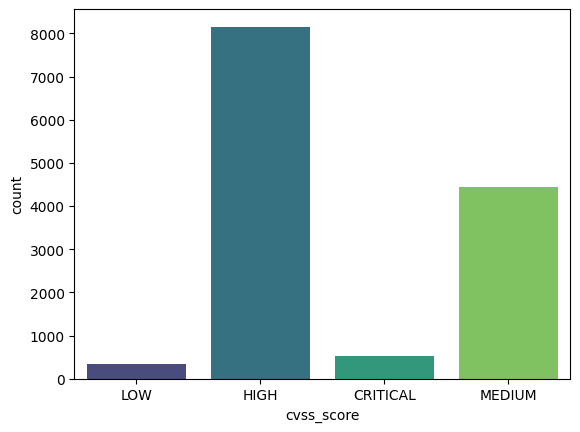

In [44]:
# Sélection un échantillon du DataFrame complet pour l'entraînement
df_sample = df_full.sample(frac=0.1, random_state=42)

# Supprimer les lignes avec des valeurs manquantes dans les colonnes nécessaires
X = df_sample.dropna(subset=["cvss_score", "n_cve_refs","days_open", "vendor", "n_revisions"]).copy()

# Garder uniquement les colonnes nécessaires
X = X[["cvss_score", "n_cve_refs", "days_open", "vendor", "n_revisions"]]

# Définir la cible (y) en classes discrètes
def map_cvss_to_class(score):
    if score < 4.0:
        return "LOW"
    elif 4.0 <= score < 7.0:
        return "MEDIUM"
    elif 7.0 <= score < 9.0:
        return "HIGH"
    else:
        return "CRITICAL"

y = X["cvss_score"].apply(map_cvss_to_class)
X = X.drop(columns=["cvss_score"])

# One Hot Encoding, convertir les colonnes catégoriques en numériques
X = pd.get_dummies(X, drop_first=True)

# Visualiser la distribution des classes
print(Counter(y))
sns.countplot(x=y, palette='viridis', hue=None)

### Equilibrage des données avec SMOTE

Counter({'LOW': 8153, 'HIGH': 8153, 'CRITICAL': 8153, 'MEDIUM': 8153})


<Axes: xlabel='cvss_score', ylabel='count'>

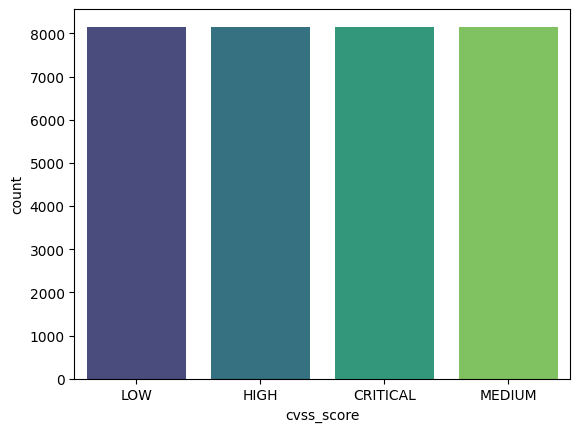

In [45]:
# Appliquer SMOTE pour équilibrer les classes
X_b, y_b = SMOTE().fit_resample(X, y)

# Visualiser la distribution des classes
print(Counter(y_b))
sns.countplot(x=y_b, palette='viridis', hue=None)

### Modèle **1** : Random Forest

Splitting des données de test et train préalable

Accuracy: 65.783.
Precision: 0.658.
Recall: 0.658.
F1 Score: 0.658.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.69      0.63      0.66      1681
        HIGH       0.54      0.74      0.63      1620
         LOW       0.76      0.83      0.80      1616
      MEDIUM       0.69      0.42      0.52      1606

    accuracy                           0.66      6523
   macro avg       0.67      0.66      0.65      6523
weighted avg       0.67      0.66      0.65      6523



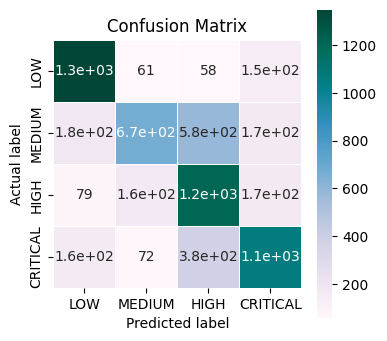

In [46]:
# Diviser les données en ensembles d'entraînement et de test
X_tr, X_te, y_tr, y_te = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

rf_b = RandomForestClassifier(random_state=42)
rf_b.fit(X_tr, y_tr)
y_pred_b = rf_b.predict(X_te)

# Fonction pour évaluer le modèle
def evaluate_model(y_true, y_pred, labels=["LOW", "MEDIUM", "HIGH", "CRITICAL"]):
    # Évaluer les performances
    acc = accuracy_score(y_true, y_pred) * 100
    pre = precision_score(y_true, y_pred, average='micro')
    rec = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')

    print("Accuracy: {:.3f}.".format(acc))
    print("Precision: {:.3f}.".format(pre))
    print("Recall: {:.3f}.".format(rec))
    print("F1 Score: {:.3f}.".format(f1))

    print("\nClassification Report")
    print(classification_report(y_true, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=.5, square=True, cmap='PuBuGn', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title("Confusion Matrix", size=12)
    plt.show()
    

# Appeler la fonction avec les labels mis à jour
evaluate_model(y_te, y_pred_b)

### Analyse des variables les plus significatives

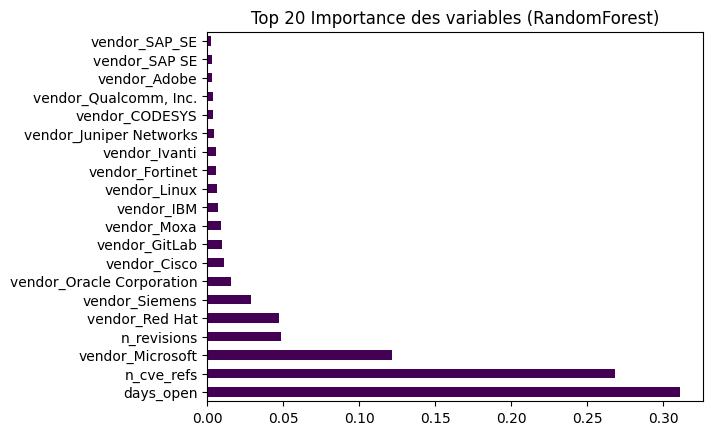

In [47]:
feature_importances = pd.Series(rf_b.feature_importances_, index=X.columns)
top_20_features = feature_importances.sort_values(ascending=False).head(20)
top_20_features.plot(kind='barh', colormap='viridis')
plt.title("Top 20 Importance des variables (RandomForest)")
plt.show()

### Hyperparameter Tuning : Random Forest

Fitting 4 folds for each of 32 candidates, totalling 128 fits
Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 200, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}
Best score is 0.6524607040683088
Accuracy: 65.798.
Precision: 0.658.
Recall: 0.658.
F1 Score: 0.658.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.69      0.63      0.66      1681
        HIGH       0.54      0.74      0.62      1620
         LOW       0.76      0.84      0.80      1616
      MEDIUM       0.69      0.42      0.52      1606

    accuracy                           0.66      6523
   macro avg       0.67      0.66      0.65      6523
weighted avg       0.67      0.66      0.65      6523



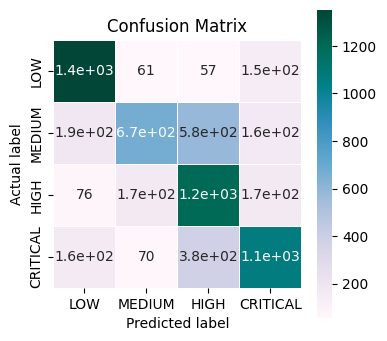

In [48]:
rf_clf_cv = RandomForestClassifier(random_state=2002)

scoring_strategy = 'f1_macro' 

param_grid = {
    'n_estimators': [1000, 2000],  # Nombre d'arbres dans la forêt
    'max_depth': [200, 300],  # Profondeur maximale des arbres
    'min_samples_split': [5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2,],     # Nombre minimum d'échantillons requis pour être à une feuille
    'max_features': ['log2', 'sqrt'],   # Nombre de caractéristiques à considérer lors de la recherche de la meilleure séparation
    'criterion': ['gini']  # Critère de qualité de la séparation
}

rf_clf_cv = GridSearchCV(rf_clf_cv, param_grid, cv=4, n_jobs=6, verbose=1, scoring=scoring_strategy)
rf_clf_cv.fit(X_tr, y_tr)

print("Tuned Random Forest Parameters: {}".format(rf_clf_cv.best_params_))
print("Best score is {}".format(rf_clf_cv.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = rf_clf_cv.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Modèle **2** : KNN (K-Nearest Neighbors)

Accuracy: 55.925.
Precision: 0.559.
Recall: 0.559.
F1 Score: 0.559.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.71      0.52      0.60      1681
        HIGH       0.55      0.26      0.36      1620
         LOW       0.64      0.86      0.73      1616
      MEDIUM       0.41      0.59      0.48      1606

    accuracy                           0.56      6523
   macro avg       0.58      0.56      0.54      6523
weighted avg       0.58      0.56      0.54      6523



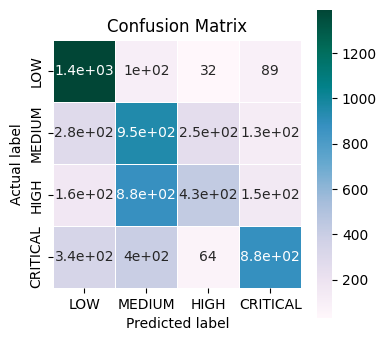

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn_b = KNeighborsClassifier(n_neighbors=5)
knn_b.fit(X_tr, y_tr)
y_pred_knn_b = knn_b.predict(X_te)

# Évaluer le modèle KNN
evaluate_model(y_te, y_pred_knn_b)

### Hyperparameter Tuning : KNN

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Tuned KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
Best score is 0.6206564415385163
Accuracy: 64.434.
Precision: 0.644.
Recall: 0.644.
F1 Score: 0.644.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.67      0.63      0.65      1681
        HIGH       0.52      0.75      0.61      1620
         LOW       0.75      0.82      0.78      1616
      MEDIUM       0.71      0.37      0.49      1606

    accuracy                           0.64      6523
   macro avg       0.66      0.64      0.64      6523
weighted avg       0.66      0.64      0.64      6523



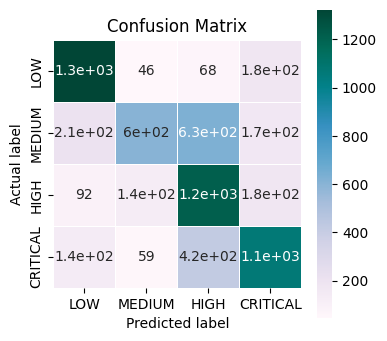

In [50]:
#HP Tunning
knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': [7, 9, 11, 14],  # Nombre de voisins à considérer
    'weights': ['uniform', 'distance'],  # Poids des voisins
    'metric': ['euclidean', 'manhattan']  # Métriques de distance
}

knn_grid = GridSearchCV(estimator = knn, param_grid = parameters, cv = 4, n_jobs = 6, verbose = 1, scoring=scoring_strategy)
knn_grid.fit(X_tr, y_tr)

print("Tuned KNN Parameters: {}".format(knn_grid.best_params_))
print("Best score is {}".format(knn_grid.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = knn_grid.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Modèle **3** : LR (Logistic Regression)

Accuracy: 53.733.
Precision: 0.537.
Recall: 0.537.
F1 Score: 0.537.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.67      0.29      0.40      1681
        HIGH       0.49      0.74      0.59      1620
         LOW       0.52      0.91      0.66      1616
      MEDIUM       0.66      0.23      0.34      1606

    accuracy                           0.54      6523
   macro avg       0.59      0.54      0.50      6523
weighted avg       0.59      0.54      0.50      6523



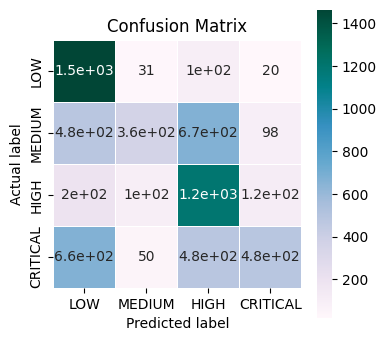

In [51]:
from sklearn.linear_model import LogisticRegression

lr_b = LogisticRegression(max_iter=5000)
lr_b.fit(X_tr, y_tr)
y_pred_lr_b = lr_b.predict(X_te)

# Évaluer le modèle de régression logistique
evaluate_model(y_te, y_pred_lr_b)

### Hyperparameter Tuning : Logistic Regression

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Tuned KNN Parameters: {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best score is 0.4974635962748216
Accuracy: 64.434.
Precision: 0.644.
Recall: 0.644.
F1 Score: 0.644.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.67      0.63      0.65      1681
        HIGH       0.52      0.75      0.61      1620
         LOW       0.75      0.82      0.78      1616
      MEDIUM       0.71      0.37      0.49      1606

    accuracy                           0.64      6523
   macro avg       0.66      0.64      0.64      6523
weighted avg       0.66      0.64      0.64      6523



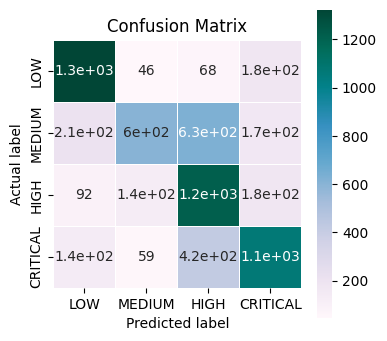

In [52]:
# LR HP Tunning
log_reg = LogisticRegression(max_iter=5000)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Inverse de la régularisation
    'penalty': ['l2'],  # Type de pénalité
    'solver': ['lbfgs', 'liblinear'],  # Algorithme d'optimisation
    'class_weight': [None, 'balanced']  # Poids des classes    
}

log_reg_cv = GridSearchCV(log_reg, param_grid, cv=4, n_jobs = 6, verbose = 1, scoring=scoring_strategy)
log_reg_cv.fit(X_tr, y_tr)

print("Tuned KNN Parameters: {}".format(log_reg_cv.best_params_))
print("Best score is {}".format(log_reg_cv.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = knn_grid.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Conclusion : 

Nous observons que le modèle le plus performant pour prédire la sévérité CVSS (classement CVSS 3.0) est la méthode Random Forest, atteignant un F1 score de **0.65** contre 0.64 pour les autres modèles.

Dans chacun des cas, la prédiction des sévérités LOW est très performantes, mais une "confusion" survient entre les sévérités MEDIUM, HIGH et CRITICAL. 

Il est utile de noté que lorsqu'on utilise la méthode de classement CVSS 2.0, contenant uniquement les trois premières catégories, nous obtenons une précision bien meilleur de **0.72**.

De même, en rajoutant seulement la variable score EPSS, notre modèle devient extrêmement performant, mais cela vient à l'encontre de notre étude qui vise à prédire une sévérité CVSS à partir de données complétements détachés (en effet le score EPSS a besoin du score CVSS pour se calculer) 


## **Résultats du modèle de regroupement (KMeans)**

Nous avons utilisé l’algorithme KMeans pour regrouper les vulnérabilités en fonction de leurs caractéristiques, sans utiliser d’étiquette de gravité. C’est une méthode non supervisée, qui cherche à créer des groupes d’éléments similaires.

Avant d’appliquer le modèle, nous avons réduit le nombre de dimensions grâce à une analyse en composantes principales (PCA). Cela permet de visualiser les données sur un graphique en deux dimensions.

Le graphique obtenu montre plusieurs groupes bien distincts. Chaque couleur représente un groupe (ou cluster) de vulnérabilités qui partagent des caractéristiques communes.
Interprétation des résultats

Les résultats montrent que les vulnérabilités peuvent être classées automatiquement en différents groupes. Chaque groupe contient des vulnérabilités qui se ressemblent :
- Un groupe peut contenir des vulnérabilités très graves, avec un score élevé et un fort risque d’exploitation.
- Un autre groupe peut regrouper des failles moins graves ou plus anciennes.
- Certains groupes sont très compacts (vulnérabilités très similaires), d'autres plus dispersés (vulnérabilités plus variées).

Cela permet de mieux comprendre les types de vulnérabilités présents dans les données.

**Utilité pour le projet**

Ce modèle est très utile pour notre projet. Il nous permet de :
classer automatiquement les vulnérabilités, même quand nous ne connaissons pas encore leur gravité, d'identifier les groupes les plus à risque, pour mieux prioriser les actions à mener, et enfin repérer des anomalies, c’est-à-dire des failles qui ne ressemblent à aucune autre.

Par exemple, si un groupe contient souvent des vulnérabilités critiques, alors toutes les nouvelles failles qui entrent dans ce groupe doivent être surveillées de près.